## run a field-level IMNN on simulations with noise

In [1]:
cd ~/repositories/wl-sbi/imnn_scripts/

/home/makinen/repositories/wl-sbi/imnn_scripts


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/makinen/venvs/lemur/lib64/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import math
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import optax
import matplotlib.pyplot as plt
from functools import partial
import flax.linen as nn

import jax.random as jr

import cloudpickle as pickle


np = jnp

from imnns import *
from imnn_update import *

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
        
def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)


%load_ext autoreload
%autoreload 2

### pull in simulations and compute MOPED for Cls WITH NOISE

In [3]:
z_means_analysis = jnp.array([0.5, 0.75, 1.0, 1.25]) #jnp.array([0.5, 1.0, 1.5, 2.0])

def indices_vector(num_tomo):
   indices = []
   cc = 0
   for catA in range(0,num_tomo,1):
      for catB in range(catA,num_tomo,1):
        indices.append([catA, catB])
        cc += 1
   return indices

N = 128
L = 250 #250
cl_cut = -1 #14 #13 #6 # 13
skip = 12 #2

OUTBINS = 6

num_tomo = 4
Lgrid = (L, L, 4000)
Nmesh = (N,N,512)
num_bins = jnp.ones(Nmesh[0]//2)[:cl_cut:skip].shape[0]
chi_grid = (jnp.arange(Nmesh[2]) + 0.5) * Lgrid[2] / Nmesh[2]
chi_source = chi_grid[-1]
indices = jnp.array(indices_vector(num_tomo))
cl_shape = indices.shape[0] * cl_cut

# NO NOISE FOR NOW
NOISEAMP = 1. / 8.


do_noise = True

def compute_variance_catalog(zmean=z_means_analysis, n_gal=30.):

    N0 = Nmesh[0]
    N1 = Nmesh[1]
    N2 = Nmesh[2]
    L0 = Lgrid[0]
    L1 = Lgrid[1]
    L2 = Lgrid[2]
    
    Ncat = 4

    cosmo = jc.Planck15(Omega_c=0.3, sigma8=0.8) # no sigma8-dependence 
    rms = 0.3 #/ 2. # from review (corrected w Hall comment)
    a = 1. / (1. + zmean)
    dist = jc.background.radial_comoving_distance(cosmo, a, log10_amin=-3, steps=256)
    angle = 2. * jnp.arctan((L0/N0/2) / dist)
    arcmin_angle = angle * 180. / np.pi * 60.
    arcmin2_pix = arcmin_angle**2
    sources = n_gal / Ncat * arcmin2_pix # from Euclid
    return rms**2 / sources

noisevars = compute_variance_catalog()

noisevars

/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Array([0.00045021, 0.00087473, 0.00134725, 0.00183411], dtype=float32)

In [4]:
@jax.jit
def rotate_sim(k, sim):
    k = k % 4

    condition1 = (k > 0)
    condition2 = (k > 1)
    condition3 = (k > 2)
    condition4 = (k == 3)

    # if k == 0:
    def kzero(k):
        return sim
    # if k == 1:
    def kone(k):
        return jnp.rot90(sim, k=1, axes=(1,2))
    # if k == 2:
    def ktwo(k):
        return jnp.rot90(sim, k=2, axes=(1,2))
    def kthree(k):
        return jnp.rot90(sim, k=3, axes=(1,2))

    # if >2, use kthree, else use ktwo
    def biggerthantwo(k):
        return jax.lax.cond(condition3, true_fun=kthree, false_fun=ktwo, operand=k)

    # if > 1, return biggerthan2, else use kone
    def biggerthanone(k):
        return jax.lax.cond(condition2, true_fun=biggerthantwo, false_fun=kone, operand=k)

    # if >0 , return biggerthan1, else use kzero
    sim = jax.lax.cond(condition1, true_fun=biggerthanone, false_fun=kzero, operand=k)

    return sim

@partial(jax.jit, static_argnums=(3,4))
def noise_simulator(key, sim, noisescale=NOISEAMP, rot=True, noisevars=noisevars):
    key1,key2 = jr.split(key)
    # do rotations of simulations
    k = jr.choice(key1, jnp.array([0,1,2,3]), shape=())
    if rot:
     sim = rotate_sim(k, sim)
    else:
     sim = sim

    # now add noise
    # this generates white noise across all pixels and then increases the amplitude
    sim += (jr.normal(key2, shape=(4,N,N)) * noisescale * jnp.sqrt(noisevars).reshape(4,1,1))
    return sim

In [5]:
from lemur import analysis, background, cosmology, limber, simulate, plot, utils, constants
from moped import *



def get_spec(index, tomo_data, key):
    
    if do_noise:
        tomo_data = noise_simulator(key, tomo_data)

    ell,cl = analysis.compute_auto_cross_angular_power_spectrum(tomo_data[index[0]], tomo_data[index[1]],
                                                chi_source, Lgrid[0])

    return jnp.histogram(ell[:cl_cut], weights=cl[:cl_cut], bins=OUTBINS)[0]
    
    # return analysis.compute_auto_cross_angular_power_spectrum(tomo_data[index[0]], tomo_data[index[1]],
    #                                             chi_source, Lgrid[0])[1][:cl_cut:skip]

def cls_allbins(tomo_data, key):
    gps = lambda i: get_spec(i, tomo_data, key)
    return jax.vmap(gps)(indices)



def get_spec_nonoise(index, tomo_data):
    
    ell,cl = analysis.compute_auto_cross_angular_power_spectrum(tomo_data[index[0]], tomo_data[index[1]],
                                                chi_source, Lgrid[0])
    return jnp.histogram(ell[:cl_cut], weights=cl[:cl_cut], bins=OUTBINS)[0]


    # return analysis.compute_auto_cross_angular_power_spectrum(tomo_data[index[0]], tomo_data[index[1]],
    #                                             chi_source, Lgrid[0])[1][:cl_cut:skip]

def cls_allbins_nonoise(tomo_data):
    gps = lambda i: get_spec_nonoise(i, tomo_data)
    return jax.vmap(gps)(indices)


In [6]:
num_bins = OUTBINS

In [7]:
num_bins

6

In [8]:
from tqdm import tqdm as tq

### ------------- IMNN PARAMETERS -------------
#θ_fid = jnp.array([0.5, 1.162]) #jnp.array([0.5, 0.67])
θ_fid = jnp.array([0.3, 0.8])
δθ = 2*jnp.array([0.0115, 0.01]) # BIG DERV STEP

θ_der = (θ_fid + jnp.einsum("i,jk->ijk", jnp.array([-1., 1.]), jnp.diag(δθ) / 2.)).reshape((-1, 2))


n_summaries = 2

n_s = 1500
n_d = 750 // 2 #125

n_params = 2
n_summaries = n_params
print(θ_der)

L = Lgrid[0]
lpt_order = 2
outdir = "/data101/makinen/lemur_sims/pm_sims/"


fid = jnp.load(outdir + "fid_S8_L_%d_N_%d_Nz_512_pm_Om_%d_s8_%d.npy"%(L, N, θ_fid[0]*10, θ_fid[1]*10)) 
#fid = jnp.load(outdir + "fid_tomo_L_%d_N_%d_Nz_512_LPT%d.npy"%(L, N, lpt_order))
derv = jnp.load(outdir + "derv_S8_smallstep_L_%d_N_%d_Nz_512_pm_Om_%d_s8_%d.npy"%(L, N, θ_fid[0]*10, θ_fid[1]*10))[:n_d*2]
#derv = jnp.load(outdir + "derv_tomo_L_%d_N_%d_Nz_512_LPT%d.npy"%(L, N, lpt_order))

key = jr.PRNGKey(7777)
key,rng = jr.split(key)

fid_keys = jr.split(key, num=2*n_s)
derv_keys = jr.split(rng, num=2*n_d)
derv_keys = jnp.repeat(derv_keys, θ_der.shape[0], axis=0) # flattened repeated keys


# ----- DO MOPED WITH ALL SIMS (NOISEFREE) -----
fid_cls = []
batch = 50
for i in tq(range(fid.shape[0] // batch)):
    f_ = jax.vmap(cls_allbins)(fid[i*batch:(i+1)*batch], fid_keys[i*batch:(i+1)*batch]).reshape(-1, len(indices)*(num_bins))
    fid_cls.append(f_)

fid_cls = jnp.concatenate(fid_cls)

derv_cls = []
batch = 50
for i in tq(range(n_d*2*2*n_params // batch)):
    d_  = jax.vmap(cls_allbins)(derv.reshape(-1, num_tomo, Nmesh[0], Nmesh[1])[i*batch:(i+1)*batch], 
                               derv_keys[i*batch:(i+1)*batch])
    derv_cls.append(d_)

derv_cls = jnp.concatenate(derv_cls).reshape(n_d*2, 2, n_params, len(indices)*(num_bins))
# ----- -----

cl_shape = derv_cls.shape[-1]
# now initialise MOPED object


[[0.2885 0.8   ]
 [0.3    0.79  ]
 [0.3115 0.8   ]
 [0.3    0.81  ]]


100%|██████████| 60/60 [00:01<00:00, 52.28it/s]


In [9]:
derv_cls.shape

(750, 2, 2, 60)

In [10]:
ell,clsfoo = analysis.compute_auto_cross_angular_power_spectrum(fid[59, 0], fid[59, 0], chi_source, Lgrid[0])
np.argmin((ell - 2000)**2)

Array(19, dtype=int32)

In [11]:
ell

Array([ 100.43279,  200.86559,  301.29837,  401.73117,  502.16397,
        602.5968 ,  703.02954,  803.46234,  903.89514, 1004.3279 ,
       1104.7607 , 1205.1936 , 1305.6262 , 1406.0591 , 1506.492  ,
       1606.9247 , 1707.3574 , 1807.7903 , 1908.2231 , 2008.6559 ,
       2109.0886 , 2209.5215 , 2309.954  , 2410.3872 , 2510.8198 ,
       2611.2524 , 2711.6855 , 2812.1182 , 2912.5508 , 3012.984  ,
       3113.4165 , 3213.8494 , 3314.2822 , 3414.7148 , 3515.148  ,
       3615.5806 , 3716.0132 , 3816.4463 , 3916.879  , 4017.3115 ,
       4117.7446 , 4218.1772 , 4318.6104 , 4419.043  , 4519.4756 ,
       4619.908  , 4720.3413 , 4820.774  , 4921.207  , 5021.6396 ,
       5122.0723 , 5222.5054 , 5322.938  , 5423.371  , 5523.8037 ,
       5624.2363 , 5724.669  , 5825.102  , 5925.5347 , 6025.968  ,
       6126.4004 , 6226.833  , 6327.2656 , 6427.6987 ], dtype=float32)

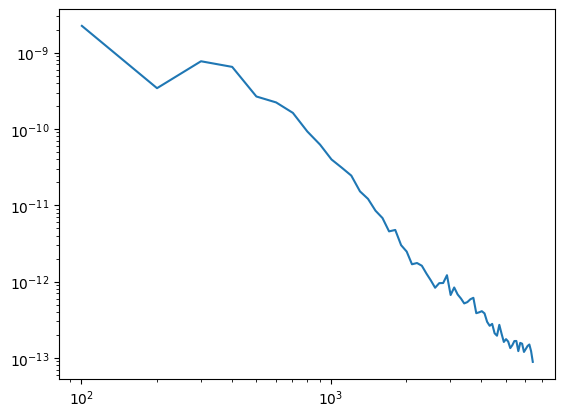

In [12]:
plt.loglog(ell, clsfoo)

In [13]:
#jnp.histogram(ell_vals, weights=power, bins=ell_bins)

clsbinnedfoo,binsfoo = jnp.histogram(ell, weights=clsfoo, bins=8)

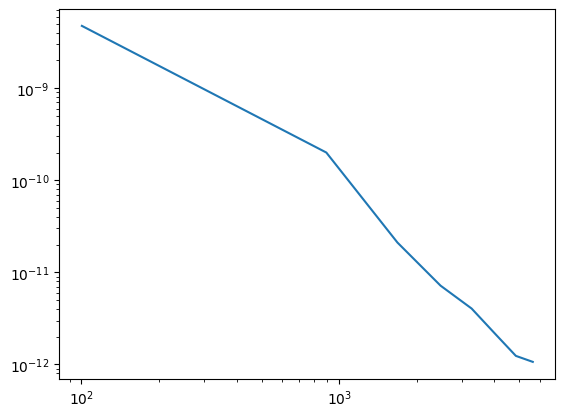

In [14]:
plt.loglog(binsfoo[:-1], clsbinnedfoo)

In [15]:
jax.config.update("jax_debug_nans", False)

# moped nonsense (functions below)

In [16]:
mymoped = MOPED(n_param=2, n_d=n_d*2, n_s=n_s*2, 
                input_shape=fid_cls[0].shape, 
                fiducial=fid_cls, 
                derivatives=derv_cls, 
                δθ=δθ, 
                θ_fid=θ_fid
               )

moped_summs = mymoped.compress(fid_cls)

# next we're going to do a second moped compression to get the derivatives into a smaller space.
# you can check to see that the fisher is the same for both !
mymoped2 = MOPED(
                n_param=2, n_d=n_d*2, n_s=n_s*2, 
                input_shape=(2,), 
                fiducial=mymoped.compress(fid_cls), 
                derivatives=mymoped.compress(derv_cls.reshape((-1,) + fid_cls[0].shape)).reshape(n_d*2, 2, 2, 2), 
                δθ=δθ, 
                θ_fid=θ_fid
)

print("moped 2 F:", mymoped2.F, "moped 1 F:", mymoped.F)
print("moped 2 F:", jnp.linalg.det(mymoped2.F), "moped 1 F:", jnp.linalg.det(mymoped.F))

moped_statistic = dict(
        n_t = 2,
        mean_derivatives = mymoped2.mu_dervs,
        covariance = mymoped.invF,
        Fisher = mymoped.F,
        fid_summaries=mymoped.compress(fid_cls),
)

moped 2 F: [[3716.8628 2027.7775]
 [2027.7775 1867.9321]] moped 1 F: [[3716.8232 2027.7457]
 [2027.7942 1867.9353]]
moped 2 F: 2830966.0 moped 1 F: 2830934.5


# train / val split

In [13]:
# split into train and val sets

val_fid = fid[n_s:]
val_derv = derv[n_d:]

fid = fid[:n_s]
derv = derv[:n_d]

(fid.shape, derv.shape), (val_fid.shape, val_derv.shape)

(((1500, 4, 128, 128), (375, 2, 2, 4, 128, 128)),
 ((1500, 4, 128, 128), (375, 2, 2, 4, 128, 128)))

# NPE code

In [11]:
from NPE import npe
from NPE.multipole_cnn import MultipoleConv
from NPE.multipole_cnn_factory import MultipoleCNNFactory
from typing import Sequence, Callable
import cloudpickle as pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

## network code

In [12]:
NOISEAMP

0.125

In [13]:
from typing import Any, Callable, Sequence, Optional, Union
from flax.core import freeze, unfreeze
import flax.linen as nn
import math
import jax
import jax.numpy as jnp

Array = Any

def fill_triangular(x):
    m = x.shape[0] # should be n * (n+1) / 2
    # solve for n
    n = int(math.sqrt((0.25 + 2 * m)) - 0.5)
    idx = jnp.array(m - (n**2 - m))
    x_tail = x[idx:]

    return jnp.concatenate([x_tail, jnp.flip(x, [0])], 0).reshape(n, n)


def fill_diagonal(a, val):
  assert a.ndim >= 2
  i, j = jnp.diag_indices(min(a.shape[-2:]))
  return a.at[..., i, j].set(val)



@jax.jit
def fill_lower_tri(v):
    m = v.shape[0]
    dim = int(math.sqrt((0.25 + 2 * m)) - 0.5)
    # we can use jax.ensure_compile_time_eval + jnp.tri to do mask indexing
    # but best practice is use numpy for static variable
    # and jnp.tril_indices is just a wrapper around np.tril_indices
    idx = np.tril_indices(dim)
    return jnp.zeros((dim, dim), dtype=v.dtype).at[idx].set(v)


# def fill_diagonal(a, val):
#     a = a.at[..., jnp.arange(0, a.shape[0]), jnp.arange(0, a.shape[0])].set(val)

#     return a


def construct_fisher_matrix_single(outputs):
    #Q = tfp.math.fill_triangular(outputs)
    Q = fill_lower_tri(outputs)
    middle = jnp.diag(jnp.tril(Q) - nn.softplus(jnp.tril(Q)))
    padding = jnp.zeros(Q.shape)
    L = Q - fill_diagonal(padding, middle)

    return jnp.einsum('...ij,...jk->...ik', L, jnp.transpose(L, (1, 0)))

@jax.jit
def almost_leaky(x: Array) -> Array:
  r"""Almost Leaky rectified linear unit activation function.

  Computes the element-wise function:

  .. math::
    \mathrm{almost\_leaky}(x) = \begin{cases}
      x, & x \leq -1\\
      - |x|^3/3, & -1 \leq x < 1\\
      3x & x > 1
    \end{cases}

  Args:
    x : input array
  """
  return jnp.where(x < -1, x, jnp.where((x < 1), ((-(jnp.abs(x)**3) / 3) + x*(x+2) + (1/3)), 3*x)) / 3.5



def next_power_of_two(number):
    # Returns next power of two following 'number'
    return math.ceil(math.log2(number))

def conv_outs(W, K=2, P=0, S=3):
    return math.ceil(((W - K + (2*P)) / S )+1)

#@jax.jit
def get_padding(arraylen):
    """
    helper function to pad uneven strided outputs
    """
    
    next_power = next_power_of_two(arraylen)
    deficit = int(math.pow(2, next_power) - arraylen) # how much extra to pad
    
    # but we want to pad both sides of a given axis, so return a tuple here
    
    left = deficit // 2
    right = left + (deficit % 2)
    
    return (left, right)


# TODO: try maxpool layer in one of the blocks ?


class InceptStride(nn.Module):
    """Inception block submodule"""
    filters: Sequence[int]
    pad_shape: int
    act: Callable = almost_leaky
    do_1x1: bool = True
    do_4x4: bool = True
    dim: int = 2

    @nn.compact
    def __call__(self, x):

        d = self.dim
            
        # 2x2 stride
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,)*self.dim, 
                     strides=(2,)*d if d == 2 else (2,2,1), 
                     padding="CIRCULAR")(x)
        z = self.act(x2)
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(z)
        x2 = self.act(x2 + z)

        # 2x2 stride with pool
        # x2p = nn.Conv(features=self.filters[0], kernel_size=(2,)*d, 
        #               strides=(2,)*d if d == 2 else (2,2,1), 
        #               padding="CIRCULAR")(x)
        # x2p = self.act(x2p)
        # x2p = nn.max_pool(x2p, (4,4), strides=None, padding="SAME")
        

        # 3x3 stride
        x3 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d, 
                     strides=(3,)*d if d == 2 else (3,3,1), 
                     padding="CIRCULAR")(x)
        z = self.act(x3)
        x3 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(z)
        x3 = self.act(x3 + z)

        # 4x4 stride
        if self.do_4x4:
            x4 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d, 
                         strides=(4,)*d if d == 2 else (4,4,1), 
                         padding="CIRCULAR")(x)
            z = self.act(x4)
            x4 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(z)
            x4 = self.act(x4 + z)

        
        # now pad the 3x3 and concatenate it to the 2x2 stride
        x3shape = conv_outs(W=self.pad_shape)
        pads = get_padding(x3shape)
        
        x3 = jnp.pad(x3, 
                     pad_width=(pads, pads, (0,0),) if d == 2 else (pads, pads, (0,0), (0,0)), 
                     mode="wrap")
        x2 = jnp.concatenate([x2, x3], -1)

        # run another conv for the concated versions
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(x2)
        x2 = self.act(x2)
        

        # optional no stride embedding
        if self.do_1x1:
            x1 = nn.Conv(features=self.filters[2], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(x)
            z = self.act(x1)
            x1 = nn.Conv(features=self.filters[2], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(z)
            x1 = self.act(x1 + z)

            return x1, x2, x4

        elif self.do_4x4:
            return x2, x4

        else:
            return x2



In [26]:
mymoped

In [27]:
MOPED

moped.MOPED

In [14]:
# TODO: should we make this layer a residual layer ?

class MPK_layer(nn.Module):
    multipole_layers: Sequence[MultipoleConv]
    act: Callable = almost_leaky

    @nn.compact
    def __call__(self, x):
        for i,l in enumerate(self.multipole_layers):
            z = l(x)
            x = self.act(z) if i == 0 else self.act(x + z)
        return x
        
# log transform
def log_transform(x):
    xo = jnp.abs(x.min(axis=0, keepdims=True)) + 0.01
    return xo * jnp.log(1.0 + (x / xo))

def clip_transform(x, clipval=0.02):
    return jnp.where(x > clipval, clipval, x)

class MDN_net_stacked(nn.Module):
    """An incept net architecture"""
    filters: Sequence[int]
    multipole_tomo1: MPK_layer
    moped: MOPED
    div_factor: float = 0.02
    n_outs: int = 1
    act: Callable = nn.swish
    
    @nn.compact
    def __call__(self, x):

        filters = self.filters

        # add in Cls information
        cls_summs = cls_allbins_nonoise(jax.lax.stop_gradient(x)).reshape(-1, cl_shape)
        cls_summs = self.moped.compress(jax.lax.stop_gradient(cls_summs)).reshape(-1) # moped compress
        xlog = (log_transform(jax.lax.stop_gradient(x)) / 0.02).transpose((1,2,0))
        x = xlog + 1.0 # jnp.concatenate([xlog, xclip, x0], -1)
        x = self.multipole_tomo1(x)

        # incept net out
        x_1_64, x_1_32 = InceptStride(filters=[1,1,1], pad_shape=128, act=self.act, do_1x1=False)(x)
        x_2_32, x_2_16 = InceptStride(filters=filters, pad_shape=64, act=self.act, do_1x1=False)(x_1_64)
        # now concatenate the remaining 32x32 arrays
        x_2_32 = jnp.concatenate([x_1_32, x_2_32], -1)
        # now cut down to 16x16
        filters = [f*2 for f in filters]
        x_3_16, x_2_8 = InceptStride(filters=filters, pad_shape=32, act=self.act, do_1x1=False)(x_2_32)
        # concatenate the remaining 16x16 array
        x_3_16 = jnp.concatenate([x_2_16, x_3_16], -1)
        # now cut down to 8x8
        filters = [f*2 for f in filters]
        x_3_8 = InceptStride(filters=filters, pad_shape=16, act=self.act, do_1x1=False, do_4x4=False)(x_3_16)
        # concatenate the 8x8s
        x = jnp.concatenate([x_2_8, x_3_8], -1)
        # take spatial mean
        x = x.mean(axis=(0,1)) #x.mean(axis=(1,2))
        x = x.reshape(-1)
        x = nn.Dense(self.n_outs)(x).reshape(1,-1)
        x = x.reshape(-1)

        return jnp.concatenate([cls_summs.reshape(-1), x])




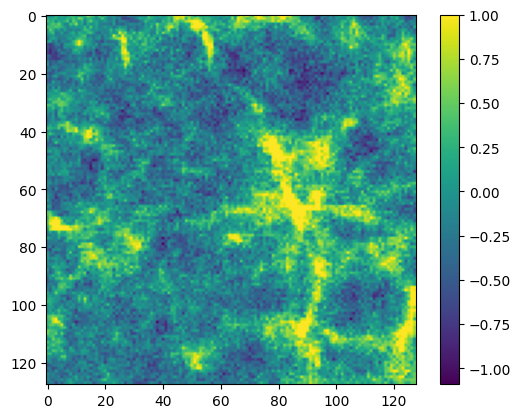

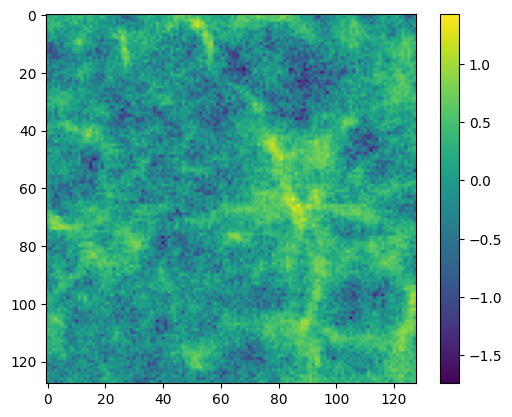

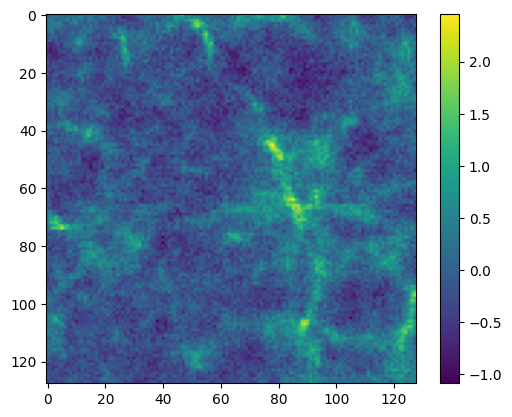

In [131]:
foo = noise_simulator(key, fid[0], rot=False)

# log transform
def log_transform(x):
    xo = jnp.abs(x.min(axis=0, keepdims=True)) + 0.01
    return xo * jnp.log(1.0 + (x / xo))

def clip_transform(x, clipval=0.02):
    return jnp.where(x > clipval, clipval, x)


clipped = clip_transform(foo) / 0.02
logged = log_transform(foo) / 0.02

plt.imshow(clipped[1, ...])
plt.colorbar()
plt.show()


plt.imshow(logged[1, ...]  + 0.1)
plt.colorbar()
plt.show()

plt.imshow(foo[1, ...] / 0.02)
plt.colorbar()
plt.show()

In [15]:
cl_shape = indices.shape[0]*num_bins

In [16]:
#@title script to get moped dependent on noise amplitdue
def get_moped_and_summaries(N, noiseamp, n_gal=30.,
                            ell_min=0, cl_cut=-1, outbins=6, bins=None, do_log=False, L=250):

    
    cl_cut = cl_cut
    skip = 12
    if bins is not None:
        OUTBINS = bins
    else:
        OUTBINS = outbins
    num_tomo = 4
    Lgrid = (L, L, 4000)
    Nmesh = (N,N,512)
    num_bins = outbins
    chi_grid = (jnp.arange(Nmesh[2]) + 0.5) * Lgrid[2] / Nmesh[2]
    chi_source = chi_grid[-1]
    indices = jnp.array(indices_vector(num_tomo))
    cl_shape = indices.shape[0] * num_bins
    
    NOISEAMP = noiseamp
    do_noise = True

    print("COMPUTING MOPED COMPRESSION FOR N=%d, NOISEAMP=%.2f, ELL_MIN=%d"%(N, noiseamp, ell_min))

    # LOAD IN SIMULATIONS AND FIND ELL_MIN 
    fid = jnp.load(outdir + "fid_S8_L_%d_N_%d_Nz_512_pm_Om_%d_s8_%d.npy"%(L, N, θ_fid[0]*10, θ_fid[1]*10)) 
    derv = jnp.load(outdir + "derv_S8_smallstep_L_%d_N_%d_Nz_512_pm_Om_%d_s8_%d.npy"%(L, N, θ_fid[0]*10, θ_fid[1]*10))[:n_d*2]
    
    key = jr.PRNGKey(7777)
    key,rng = jr.split(key)
    
    fid_keys = jr.split(key, num=2*n_s)
    derv_keys = jr.split(rng, num=2*n_d)
    derv_keys = jnp.repeat(derv_keys, θ_der.shape[0], axis=0) # flattened repeated keys

    # compute the ells and find the argmin
    ell,clsfoo = analysis.compute_auto_cross_angular_power_spectrum(fid[59, 0], fid[59, 0], chi_source, Lgrid[0])
    ellmin = np.argmin((ell - ell_min)**2)

    print("MINIMUM ELL IDX: ", ellmin)


    def compute_variance_catalog(zmean=z_means_analysis, n_gal=n_gal):
    
        N0 = Nmesh[0]
        N1 = Nmesh[1]
        N2 = Nmesh[2]
        L0 = Lgrid[0]
        L1 = Lgrid[1]
        L2 = Lgrid[2]
        
        Ncat = 4
    
        cosmo = jc.Planck15(Omega_c=0.3, sigma8=0.8) # no sigma8-dependence 
        rms = 0.3 #/ 2. # from review (corrected w Hall comment)
        a = 1. / (1. + zmean)
        dist = jc.background.radial_comoving_distance(cosmo, a, log10_amin=-3, steps=256)
        angle = 2. * jnp.arctan((L0/N0/2) / dist)
        arcmin_angle = angle * 180. / np.pi * 60.
        arcmin2_pix = arcmin_angle**2
        sources = n_gal / Ncat * arcmin2_pix # from Euclid
        return rms**2 / sources

    noisevars = compute_variance_catalog()

    print("NOISEVARS", noisevars)
    print("SCALED NOISE SIGMAS", jnp.sqrt(noisevars) * noiseamp)

    #@partial(jax.jit, static_argnums=(3,4))
    def noise_simulator(key, sim, noisescale=noiseamp, rot=True, noisevars=noisevars):
        key1,key2 = jr.split(key)
        # do rotations of simulations
        k = jr.choice(key1, jnp.array([0,1,2,3]), shape=())
        if rot:
         sim = rotate_sim(k, sim)
        else:
         sim = sim
    
        # now add noise
        # this generates white noise across all pixels and then increases the amplitude
        sim += (jr.normal(key2, shape=(4,N,N)) * noisescale * jnp.sqrt(noisevars).reshape(4,1,1))
        return sim


    def get_spec_nonoise(index, tomo_data):
        ell,cl = analysis.compute_auto_cross_angular_power_spectrum(tomo_data[index[0]], tomo_data[index[1]],
                                                    chi_source, Lgrid[0])
        if do_log:
            ell = jnp.log(ell)
        return jnp.histogram(ell[ellmin:cl_cut], weights=cl[ellmin:cl_cut], bins=OUTBINS)[0]
    
        
    def cls_allbins_nonoise(tomo_data):
        gps = lambda i: get_spec_nonoise(i, tomo_data)
        return jax.vmap(gps)(indices)

    #### DEFINE FUNCTION TO GET MOPED STATISTIC FOR GIVEN CONFIGURATION
    def get_moped_statistic(noiseamp):
    
        def get_spec(index, tomo_data, key):
            
            tomo_data = noise_simulator(key, tomo_data, noisescale=noiseamp)
            ell,cl = analysis.compute_auto_cross_angular_power_spectrum(tomo_data[index[0]], tomo_data[index[1]],
                                                        chi_source, Lgrid[0])
            if do_log:
                ell = jnp.log(ell)
        
            return jnp.histogram(ell[ellmin:cl_cut], weights=cl[ellmin:cl_cut], bins=OUTBINS)[0]
        
        def cls_allbins(tomo_data, key):
            gps = lambda i: get_spec(i, tomo_data, key)
            return jax.vmap(gps)(indices)

        
        
        # ----- DO MOPED WITH ALL SIMS (NOISEFREE) -----
        fid_cls = []
        batch = 50
        for i in tq(range(fid.shape[0] // batch)):
            f_ = jax.vmap(cls_allbins)(fid[i*batch:(i+1)*batch], fid_keys[i*batch:(i+1)*batch]).reshape(-1, len(indices)*(num_bins))
            fid_cls.append(f_)
        
        fid_cls = jnp.concatenate(fid_cls)
        
        derv_cls = []
        batch = 50
        for i in tq(range(n_d*2*2*n_params // batch)):
            d_  = jax.vmap(cls_allbins)(derv.reshape(-1, num_tomo, Nmesh[0], Nmesh[1])[i*batch:(i+1)*batch], 
                                       derv_keys[i*batch:(i+1)*batch])
            derv_cls.append(d_)
        
        derv_cls = jnp.concatenate(derv_cls).reshape(n_d*2, 2, n_params, len(indices)*(num_bins))
        # ----- -----
        
        cl_shape = derv_cls.shape[-1]
    
    
        mymoped = MOPED(n_param=2, n_d=n_d*2, n_s=n_s*2, 
                        input_shape=fid_cls[0].shape, 
                        fiducial=fid_cls, 
                        derivatives=derv_cls, 
                        δθ=δθ, 
                        θ_fid=θ_fid
                       )
        
        moped_summs = mymoped.compress(fid_cls)
        
        # next we're going to do a second moped compression to get the derivatives into a smaller space.
        # you can check to see that the fisher is the same for both !
        mymoped2 = MOPED(
                        n_param=2, n_d=n_d*2, n_s=n_s*2, 
                        input_shape=(2,), 
                        fiducial=mymoped.compress(fid_cls), 
                        derivatives=mymoped.compress(derv_cls.reshape((-1,) + fid_cls[0].shape)).reshape(n_d*2, 2, 2, 2), 
                        δθ=δθ, 
                        θ_fid=θ_fid
        )
        
        print("moped 2 F:", mymoped2.F, "moped 1 F:", mymoped.F)
        print("moped 2 F:", jnp.linalg.det(mymoped2.F), "moped 1 F:", jnp.linalg.det(mymoped.F))
        
        moped_statistic = dict(
                n_t = 2,
                mean_derivatives = mymoped2.mu_dervs,
                covariance = mymoped.invF,
                Fisher = mymoped.F,
                fid_summaries=mymoped.compress(fid_cls),
        )
        # spits out dictionary to feed to network
        return mymoped, moped_statistic


    mymoped, moped_statistic = get_moped_statistic(noiseamp)

    return mymoped, moped_statistic


In [17]:
mymoped, moped_stat_test = get_moped_and_summaries(N=128, noiseamp=1./4., n_gal=50.)

COMPUTING MOPED COMPRESSION FOR N=128, NOISEAMP=0.25, ELL_MIN=0
MINIMUM ELL IDX:  0
NOISEVARS [0.00027013 0.00052484 0.00080835 0.00110046]
SCALED NOISE SIGMAS [0.00410888 0.00572733 0.00710788 0.00829331]


100%|██████████| 60/60 [00:01<00:00, 37.17it/s]


moped 2 F: [[3121.5117 1879.4464]
 [1879.4463 1638.4148]] moped 1 F: [[3121.5264 1879.4475]
 [1879.4669 1638.4172]]
moped 2 F: 1582012.5 moped 1 F: 1582003.0


In [18]:
# initialise network with mymoped

mpk_layer = MultipoleCNNFactory(
             kernel_shape=(7,7),
            #kernel_shape=(7,7),
             polynomial_degrees=[0,1,2],
             output_filters=None)


strides1 = [1,1]
strides2 = [1,1]
strides3 = [1,1]
strides4 = [1,1]
strides5 = [1,1]

input_filters1 = [4,1,1]
input_filters_rest = [4, 6]
act = almost_leaky

model = MDN_net_stacked(filters=[1,1,1],
                        # rest of network
                        multipole_tomo1 = MPK_layer(multipole_layers=[mpk_layer.build_cnn_model(num_input_filters=f,
                                                                   strides=strides1[i],
                                                                   pad_size=None) for i,f in enumerate(input_filters_rest)],
                                                                   act=act),
                        moped=mymoped,
                        act=act, 
                        n_outs=2
)

w = model.init(jr.PRNGKey(44), jnp.zeros((4, N, N)))
x = model.apply(w, noise_simulator(key, fid[0]))

x




Array([ 0.48734844,  0.15559989, -0.9628941 , -0.40751857], dtype=float32)

In [32]:
import netket as nk
from jax import config
config.update("jax_enable_x64", False)

In [33]:
from imnns import *
from imnn_update import *
from imnn_update import _updateIMNN, _check_input
import netket as nk




# NOISE NUMERICAL GRADIENT IMNN
class newNoiseNumericalGradientIMNN(_updateIMNN):
    """Information maximising neural network fit with simulations on-the-fly
    """
    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid, δθ,
                 model, optimiser, key_or_state,
                 noise_simulator, 
                 fiducial, derivative,
                 chunk_size=100,
                 validation_fiducial=None, validation_derivative=None, 
                 existing_statistic=None,
                 dummy_graph_input=None,
                 no_invC=False, do_reg=True,
                 evidence=False):
        """Constructor method

        Initialises all IMNN attributes, constructs neural network and its
        initial parameter values and creates history dictionary. Also checks
        validity of simulator and sets the ``simulate`` attribute to ``True``.

        Parameters
        ----------
        n_s : int
            Number of simulations used to calculate summary covariance
        n_d : int
            Number of simulations used to calculate mean of summary derivative
        n_params : int
            Number of model parameters
        n_summaries : int
            Number of summaries, i.e. outputs of the network
        input_shape : tuple
            The shape of a single input to the network
        θ_fid : float(n_params,)
            The value of the fiducial parameter values used to generate inputs
        model : tuple, len=2
            Tuple containing functions to initialise neural network
            ``fn(rng: int(2), input_shape: tuple) -> tuple, list`` and the
            neural network as a function of network parameters and inputs
            ``fn(w: list, d: float(None, input_shape)) -> float(None, n_summari
            es)``.
            (Essentibly stax-like, see `jax.experimental.stax <https://jax.read
            thedocs.io/en/stable/jax.experimental.stax.html>`_))
        optimiser : tuple, len=3
            Tuple containing functions to generate the optimiser state
            ``fn(x0: list) -> :obj:state``, to update the state from a list of
            gradients ``fn(i: int, g: list, state: :obj:state) -> :obj:state``
            and to extract network parameters from the state
            ``fn(state: :obj:state) -> list``.
            (See `jax.experimental.optimizers <https://jax.readthedocs.io/en/st
            able/jax.experimental.optimizers.html>`_)
        key_or_state : int(2) or :obj:state
            Either a stateless random number generator or the state object of
            an preinitialised optimiser
        simulator : fn
            A function that generates a single simulation from a random number
            generator and a tuple (or array) of parameter values at which to
            generate the simulations. For the purposes of use in LFI/ABC
            afterwards it is also useful for the simulator to be able to
            broadcast to a batch of simulations on the zeroth axis
            ``fn(int(2,), float([None], n_params)) ->
            float([None], input_shape)``
        dummy_graph_input : jraph.GraphsTuple or 'jax.numpy.DeviceArray'
            Either a (padded) graph input or device array. If supplied ignores 
            `input_shape` parameter
        """
        super().__init__(
            n_s=n_s,
            n_d=n_d,
            n_params=n_params,
            n_summaries=n_summaries,
            input_shape=input_shape,
            θ_fid=θ_fid,
            model=model,
            optimiser=optimiser,
            key_or_state=key_or_state,
            existing_statistic=existing_statistic,
            dummy_graph_input=dummy_graph_input,
            no_invC=no_invC,
            do_reg=do_reg,
            evidence=evidence)

        self.chunk_size = chunk_size
        self.existing_statistic = existing_statistic
        self.simulator = noise_simulator
        #self.simulate = True
        self.dummy_graph_input = dummy_graph_input
        self.θ_der = (θ_fid + np.einsum("i,jk->ijk", np.array([-1., 1.]), 
                                        np.diag(δθ) / 2.)).reshape((-1, 2))
        self.δθ = np.expand_dims(
            _check_input(δθ, (self.n_params,), "δθ"), (0, 1))
        
        # NUMERICAL GRADIENT SETUP
        self._set_data(δθ, fiducial, derivative, validation_fiducial,
                       validation_derivative)


    def _set_data(self, δθ, fiducial, derivative, validation_fiducial,
                  validation_derivative):
        """Checks and sets data attributes with the correct shape
        """
        self.δθ = np.expand_dims(
            _check_input(δθ, (self.n_params,), "δθ"), (0, 1))
        if self.dummy_graph_input is None:
          self.fiducial = _check_input(
              fiducial, (self.n_s,) + self.input_shape, "fiducial")
          self.derivative = _check_input(
              derivative, (self.n_d, 2, self.n_params) + self.input_shape,
              "derivative")
          if ((validation_fiducial is not None)
                  and (validation_derivative is not None)):
              self.validation_fiducial = _check_input(
                  validation_fiducial, (self.n_s,) + self.input_shape,
                  "validation_fiducial")
              self.validation_derivative = _check_input(
                  validation_derivative,
                  (self.n_d, 2, self.n_params) + self.input_shape,
                  "validation_derivative")
              self.validate = True
        else:
          self.fiducial = fiducial
          self.derivative = derivative

          if ((validation_fiducial is not None)
                  and (validation_derivative is not None)):
              self.validation_fiducial = validation_fiducial
              self.validation_derivative =  validation_derivative
              self.validate = True


    def _collect_input(self, key, validate=False):
        """ Returns validation or fitting sets
        """
        if validate:
            fiducial = self.validation_fiducial
            derivative = self.validation_derivative
        else:
            fiducial = self.fiducial
            derivative = self.derivative
            
        # add noise to data and make cuts
        keys = np.array(jax.random.split(key, num=self.n_s))
        fiducial = jax.vmap(self.simulator)(keys, fiducial)
        
        _shape = derivative.shape
        derivative = jax.vmap(self.simulator)(
                np.repeat(keys[:self.n_d], 2*self.n_params, axis=0),
                derivative.reshape(
                      (self.n_d * 2 * self.n_params,) + self.input_shape)).reshape(_shape)
                      
        return fiducial, derivative

    def _get_fitting_keys(self, rng):
        """Generates random numbers for simulation

        Parameters
        ----------
        rng : int(2,)
            A random number generator

        Returns
        -------
        int(2,), int(2,), int(2,)
            A new random number generator and random number generators for
            fitting (and validation)
        """
        return jax.random.split(rng, num=3)

    def get_summaries(self, w, key=None, validate=False):
        """Gets all network outputs and derivatives wrt model parameters
        """
        d, d_mp = self._collect_input(key, validate=validate)
        
        
        if self.dummy_graph_input is None:
          _model = lambda d: self.model(w, d)
          # try the netket batched vmap
          # nk.jax.vmap_chunked(f, in_axes=0, *, chunk_size, axis_0_is_sharded=False)
          x = nk.jax.vmap_chunked(_model, chunk_size=self.chunk_size)(d)
          x_mp = np.reshape(
              nk.jax.vmap_chunked(_model, chunk_size=self.chunk_size)(
                    d_mp.reshape(
                      (self.n_d * 2 * self.n_params,) + self.input_shape)),
              (self.n_d, 2, self.n_params, self.n_summaries))

        else:
          # if operating on graph data, we need to vmap the implicit
          # batch dimension
          _model = lambda d: self.model(w, d)
          x = jax.vmap(_model)(d)
          x_mp = np.reshape(
              jax.vmap(_model)(d_mp),
              (self.n_d, 2, self.n_params, self.n_summaries))

        return x, x_mp

    def _construct_derivatives(self, x_mp):
        """Builds derivatives of the network outputs wrt model parameters
        """
        return np.swapaxes(x_mp[:, 1] - x_mp[:, 0], 1, 2) / self.δθ


In [104]:
lr_schedule = optax.exponential_decay(init_value=1e-4, 
                        transition_begin=80,
                        transition_steps=150, 
                        decay_rate=0.5, 
                        end_value=1e-5
                       )

# Clip gradients at max value, and evt. apply weight decay
transf = [optax.clip(1.0)]
transf.append(optax.add_decayed_weights(1e-4))
optimiser = optax.chain(
    *transf,
    #optax.sgd(learning_rate=5e-4, momentum=0.9)
    optax.adam(learning_rate=5e-4)
)

model_key = jr.PRNGKey(44)
key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (4, N, N)


# insatiate new moped statistic with higher noise settings
NOISEAMP = 1./4.
mymoped, moped_stat = get_moped_and_summaries(N=128, noiseamp=NOISEAMP, n_gal=30.)

IMNN =  newNoiseNumericalGradientIMNN(
    n_s=n_s, n_d=n_d, n_params=n_params, n_summaries=2 + 2,
    input_shape=input_shape, θ_fid=θ_fid, δθ=δθ, model=model,
    optimiser=optimiser, key_or_state=jnp.array(model_key),
    noise_simulator=(lambda rng, d: noise_simulator(
           rng, d, noisescale=NOISEAMP, rot=True)),
    chunk_size=50,
    fiducial=val_fid, 
    derivative=val_derv,
    validation_fiducial=fid,
    validation_derivative=derv,
    #existing_statistic=None,
    existing_statistic=moped_stat,
    no_invC=True, # True
    evidence=True
)
wbest = load_obj(outdir + "imnn_w_N_%d_2out_low_noise_0.pkl"%(N))
IMNN.set_F_statistics(wbest, key)
IMNN.F, mymoped.F # detF 2830889.0

COMPUTING MOPED COMPRESSION FOR N=128, NOISEAMP=0.25, ELL_MIN=0
MINIMUM ELL IDX:  0
NOISEVARS [0.00045021 0.00087473 0.00134725 0.00183411]
SCALED NOISE SIGMAS [0.00530454 0.00739395 0.00917623 0.01070662]


100%|██████████| 60/60 [00:01<00:00, 37.61it/s]


moped 2 F: [[2824.4692 1762.2106]
 [1762.2106 1467.5176]] moped 1 F: [[2824.47   1762.2112]
 [1762.1864 1467.4973]]
moped 2 F: 1039572.25 moped 1 F: 1039557.5


(Array([[5858.79  , 2236.5183],
        [2236.518 , 1599.0406]], dtype=float32),
 Array([[2824.47  , 1762.2112],
        [1762.1864, 1467.4973]], dtype=float32))

In [139]:
1/8 + 0.1

0.225

In [147]:
from tqdm import tqdm as tq

-----------------------
RETRAINING FOR NOISEAMP:  0.15
-----------------------
COMPUTING MOPED COMPRESSION FOR N=128, NOISEAMP=0.15, ELL_MIN=0
MINIMUM ELL IDX:  0


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


NOISEVARS [0.00045021 0.00087473 0.00134725 0.00183411]
SCALED NOISE SIGMAS [0.00318272 0.00443637 0.00550574 0.00642397]


100%|██████████| 60/60 [00:01<00:00, 33.09it/s]


moped 2 F: [[3445.228  1970.735 ]
 [1970.7352 1782.6145]] moped 1 F: [[3445.2734 1970.7886]
 [1970.7366 1782.6115]]
moped 2 F: 2257716.8 moped 1 F: 2257679.0
MOPED F:  [[3445.2734 1970.7886]
 [1970.7366 1782.6115]]
initial IMNN F:  [[8757.49   2571.8909]
 [2571.891  1955.2134]]
initial IMNN_F / MOPED_F : 4.6543984
training IMNN now


0it [00:00, ?it/s]

MOPED F:  [[3445.2734 1970.7886]
 [1970.7366 1782.6115]]
final IMNN F:  [[8883.146  2642.065 ]
 [2642.0652 1987.8087]]
final IMNN_F / MOPED_F : 4.729409


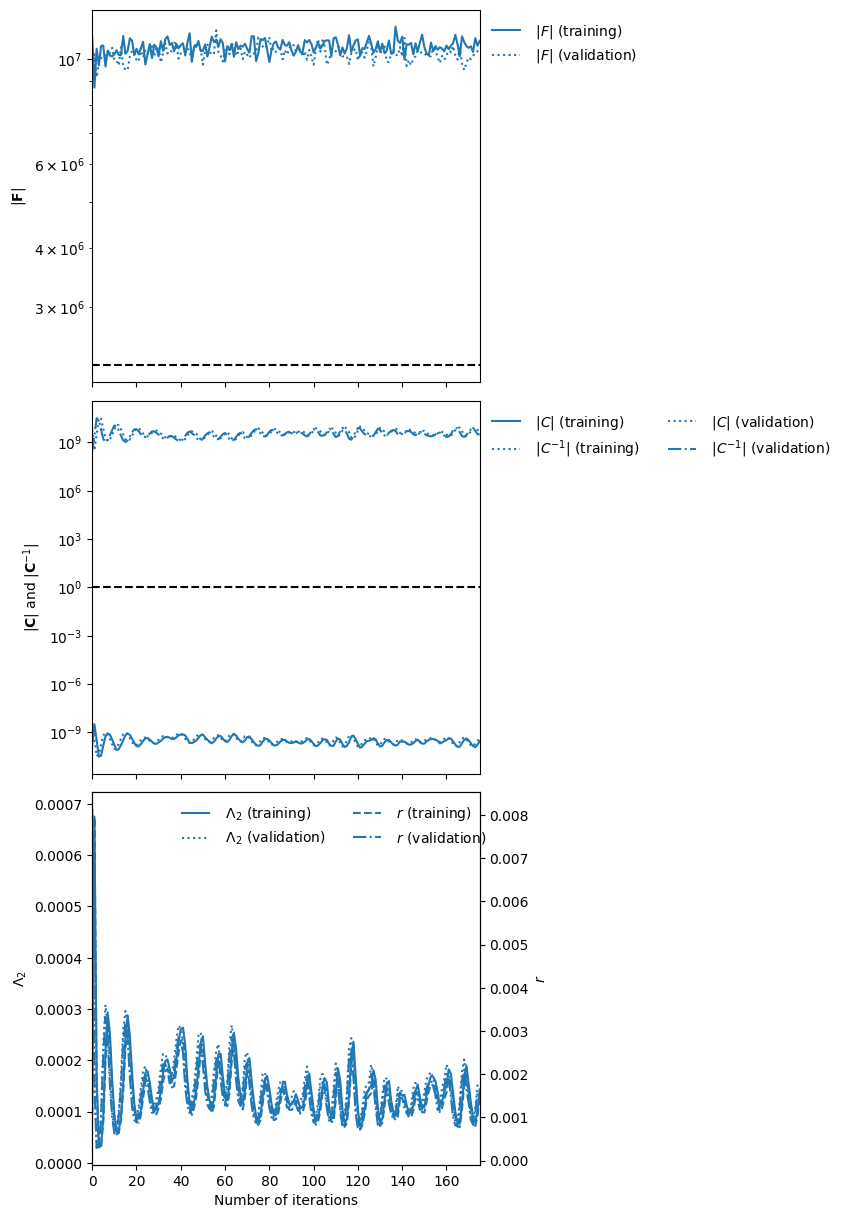

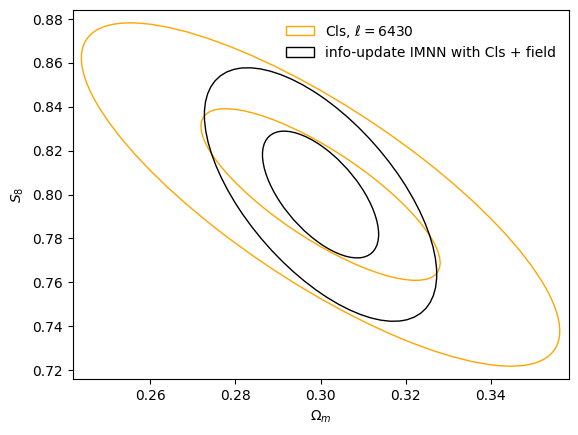

COMPRESSING PRIOR


100%|██████████| 100/100 [00:02<00:00, 45.94it/s]


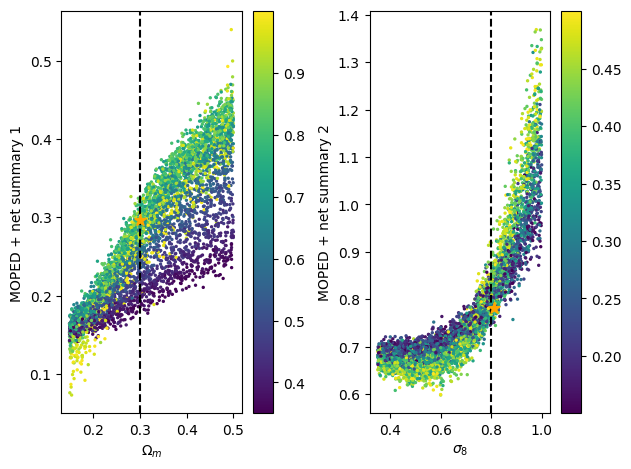

saving everything
-----------------------
RETRAINING FOR NOISEAMP:  0.2
-----------------------
COMPUTING MOPED COMPRESSION FOR N=128, NOISEAMP=0.20, ELL_MIN=0
MINIMUM ELL IDX:  0
NOISEVARS [0.00045021 0.00087473 0.00134725 0.00183411]
SCALED NOISE SIGMAS [0.00424363 0.00591516 0.00734098 0.00856529]


100%|██████████| 60/60 [00:01<00:00, 33.86it/s]


moped 2 F: [[3083.768  1866.4148]
 [1866.4149 1618.0851]] moped 1 F: [[3083.8738 1866.4928]
 [1866.4619 1618.1206]]
moped 2 F: 1506294.5 moped 1 F: 1506341.8
MOPED F:  [[3083.8738 1866.4928]
 [1866.4619 1618.1206]]
initial IMNN F:  [[7188.297  2462.193 ]
 [2462.193  1808.8683]]
initial IMNN_F / MOPED_F : 4.6073785
training IMNN now


0it [00:00, ?it/s]

MOPED F:  [[3083.8738 1866.4928]
 [1866.4619 1618.1206]]
final IMNN F:  [[7388.942 2420.963]
 [2420.963 1787.062]]
final IMNN_F / MOPED_F : 4.875013


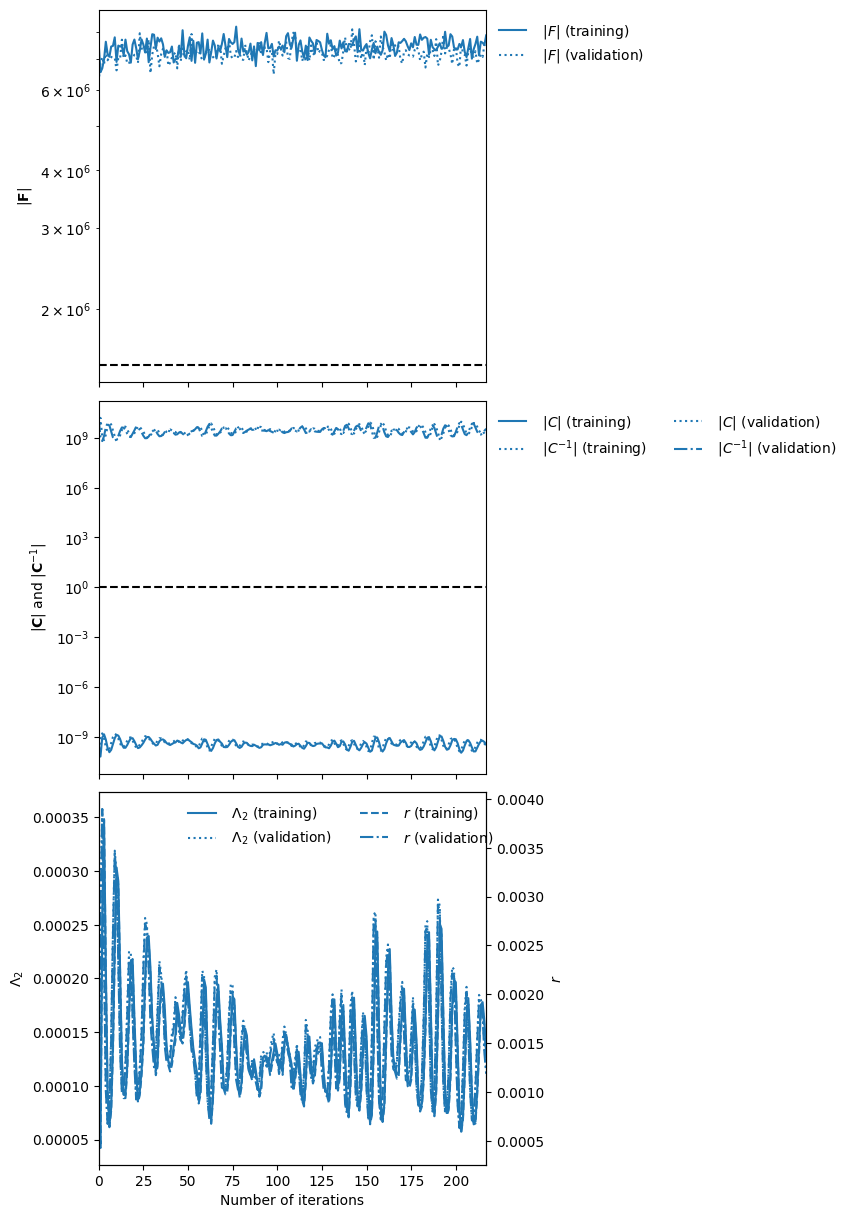

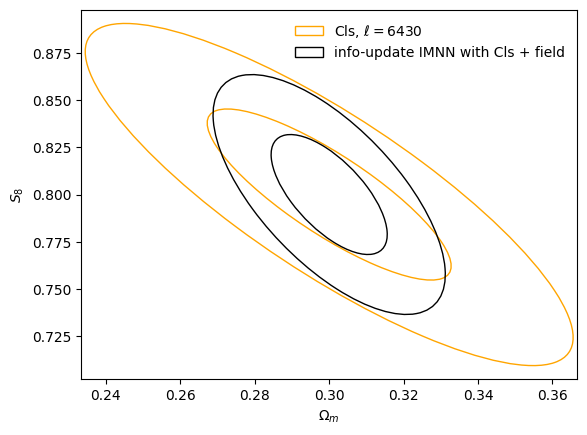

COMPRESSING PRIOR


100%|██████████| 100/100 [00:02<00:00, 47.48it/s]


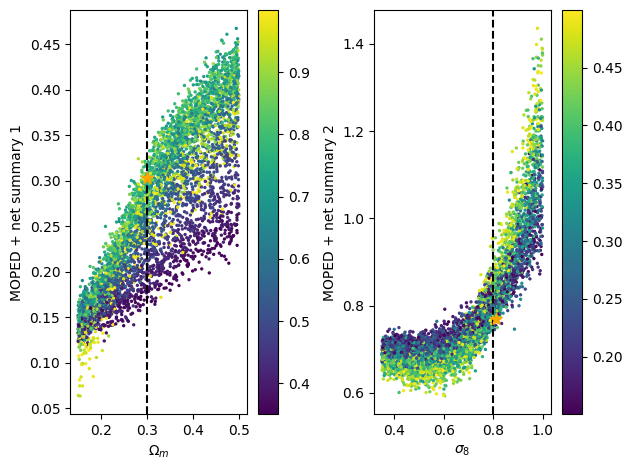

saving everything
-----------------------
RETRAINING FOR NOISEAMP:  0.3
-----------------------
COMPUTING MOPED COMPRESSION FOR N=128, NOISEAMP=0.30, ELL_MIN=0
MINIMUM ELL IDX:  0
NOISEVARS [0.00045021 0.00087473 0.00134725 0.00183411]
SCALED NOISE SIGMAS [0.00636544 0.00887274 0.01101148 0.01284794]


100%|██████████| 60/60 [00:01<00:00, 33.97it/s]


moped 2 F: [[2598.7068 1653.6154]
 [1653.6154 1336.0157]] moped 1 F: [[2598.7134 1653.62  ]
 [1653.6248 1336.0269]]
moped 2 F: 737469.5 moped 1 F: 737483.75
MOPED F:  [[2598.7134 1653.62  ]
 [1653.6248 1336.0269]]
initial IMNN F:  [[5193.0244 2130.0571]
 [2130.0574 1504.3143]]
initial IMNN_F / MOPED_F : 4.4405007
training IMNN now


0it [00:00, ?it/s]

MOPED F:  [[2598.7134 1653.62  ]
 [1653.6248 1336.0269]]
final IMNN F:  [[5367.991  2095.595 ]
 [2095.5947 1473.0505]]
final IMNN_F / MOPED_F : 4.7672977


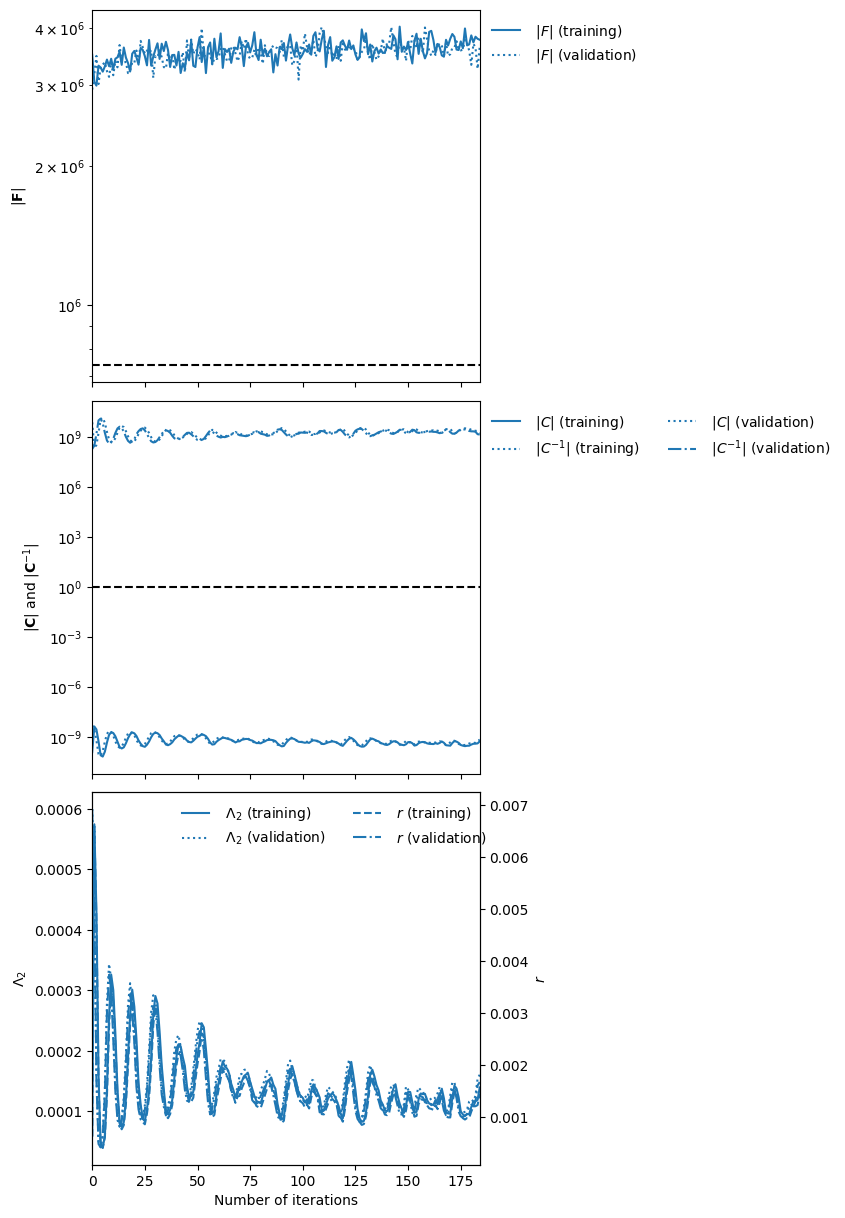

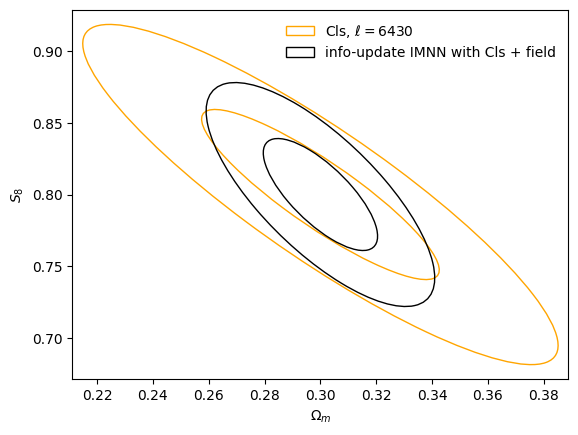

COMPRESSING PRIOR


100%|██████████| 100/100 [00:02<00:00, 43.80it/s]


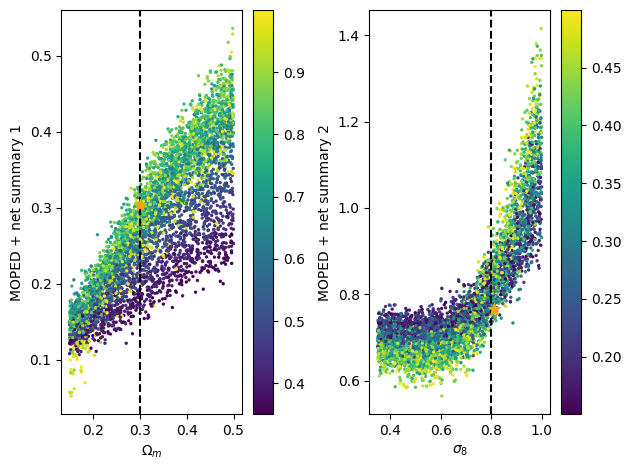

saving everything
-----------------------
RETRAINING FOR NOISEAMP:  0.4
-----------------------
COMPUTING MOPED COMPRESSION FOR N=128, NOISEAMP=0.40, ELL_MIN=0
MINIMUM ELL IDX:  0
NOISEVARS [0.00045021 0.00087473 0.00134725 0.00183411]
SCALED NOISE SIGMAS [0.00848726 0.01183032 0.01468197 0.01713059]


100%|██████████| 60/60 [00:01<00:00, 35.04it/s]


moped 2 F: [[2186.8936 1429.3359]
 [1429.3359 1118.574 ]] moped 1 F: [[2186.856  1429.3046]
 [1429.3135 1118.5522]]
moped 2 F: 403201.0 moped 1 F: 403188.5
MOPED F:  [[2186.856  1429.3046]
 [1429.3135 1118.5522]]
initial IMNN F:  [[3860.1802 1791.3708]
 [1791.3708 1258.7748]]
initial IMNN_F / MOPED_F : 4.092597
training IMNN now


0it [00:00, ?it/s]

MOPED F:  [[2186.856  1429.3046]
 [1429.3135 1118.5522]]
final IMNN F:  [[4139.7866 1786.8518]
 [1786.8518 1226.1422]]
final IMNN_F / MOPED_F : 4.6705885


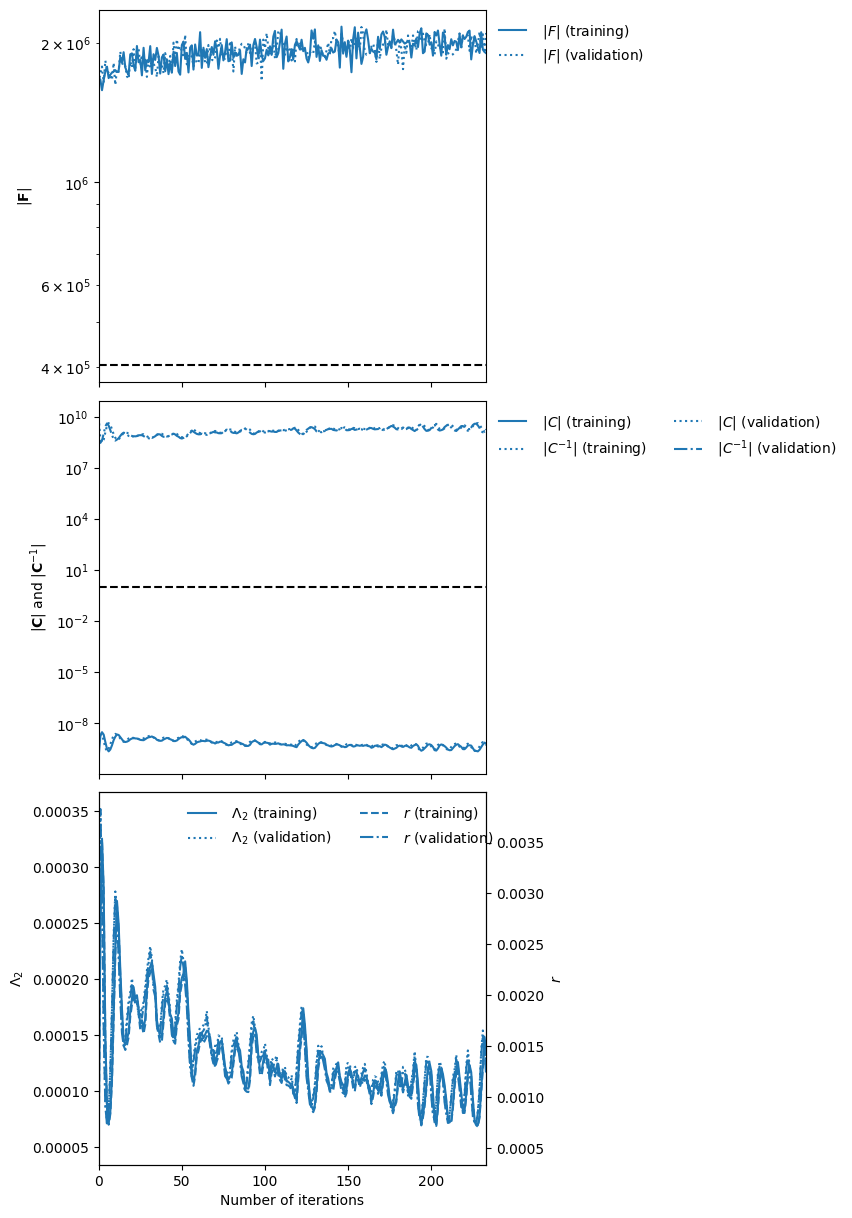

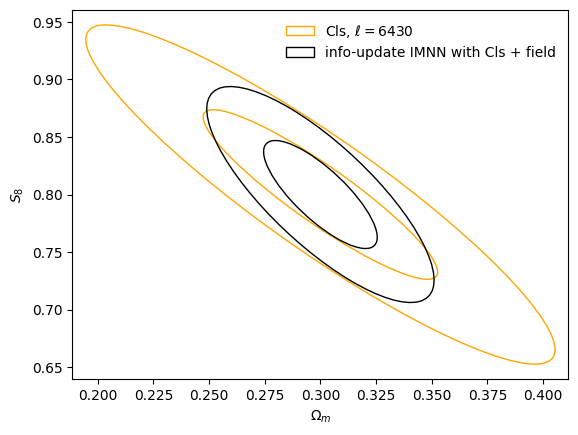

COMPRESSING PRIOR


100%|██████████| 100/100 [00:02<00:00, 46.30it/s]


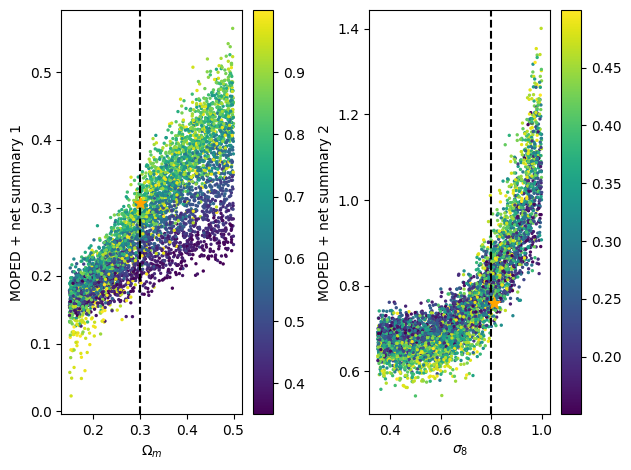

saving everything
-----------------------
RETRAINING FOR NOISEAMP:  0.5
-----------------------
COMPUTING MOPED COMPRESSION FOR N=128, NOISEAMP=0.50, ELL_MIN=0
MINIMUM ELL IDX:  0
NOISEVARS [0.00045021 0.00087473 0.00134725 0.00183411]
SCALED NOISE SIGMAS [0.01060907 0.0147879  0.01835246 0.02141323]


100%|██████████| 60/60 [00:01<00:00, 35.78it/s]


moped 2 F: [[1812.0883  1208.6864 ]
 [1208.6865   936.67865]] moped 1 F: [[1812.0928  1208.69   ]
 [1208.687    936.67914]]
moped 2 F: 236421.38 moped 1 F: 236421.62
MOPED F:  [[1812.0928  1208.69   ]
 [1208.687    936.67914]]
initial IMNN F:  [[3222.9336 1551.9832]
 [1551.9832 1066.217 ]]
initial IMNN_F / MOPED_F : 4.3468738
training IMNN now


0it [00:00, ?it/s]

MOPED F:  [[1812.0928  1208.69   ]
 [1208.687    936.67914]]
final IMNN F:  [[3348.3472 1535.6123]
 [1535.612  1025.5585]]
final IMNN_F / MOPED_F : 4.550434


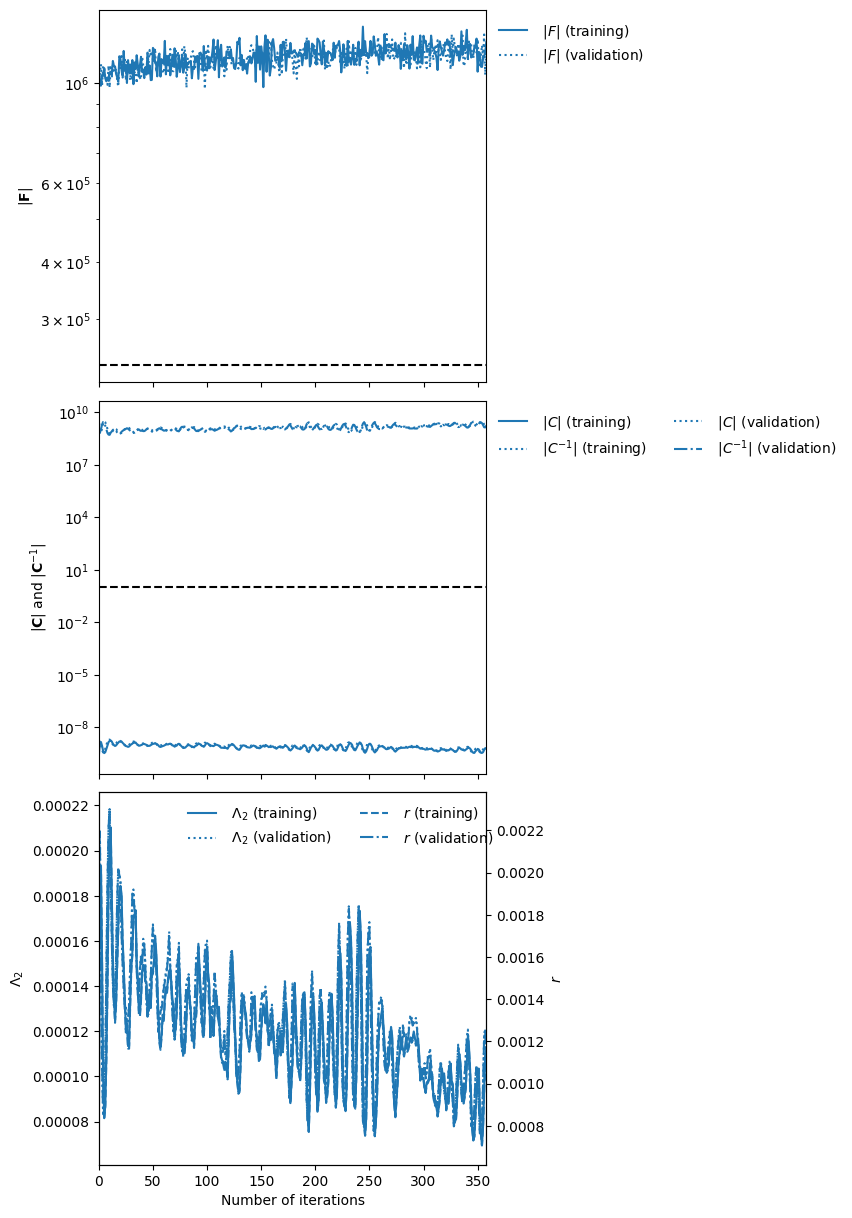

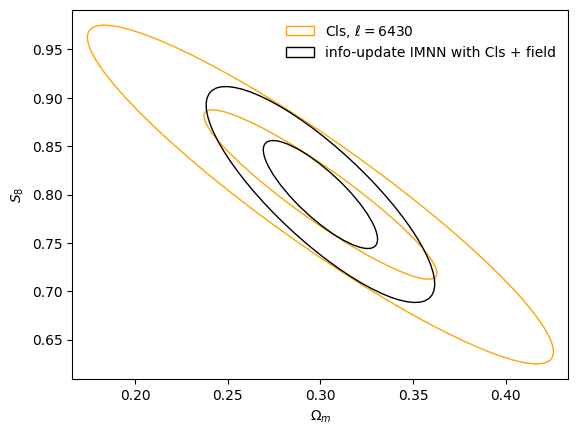

COMPRESSING PRIOR


100%|██████████| 100/100 [00:02<00:00, 46.47it/s]


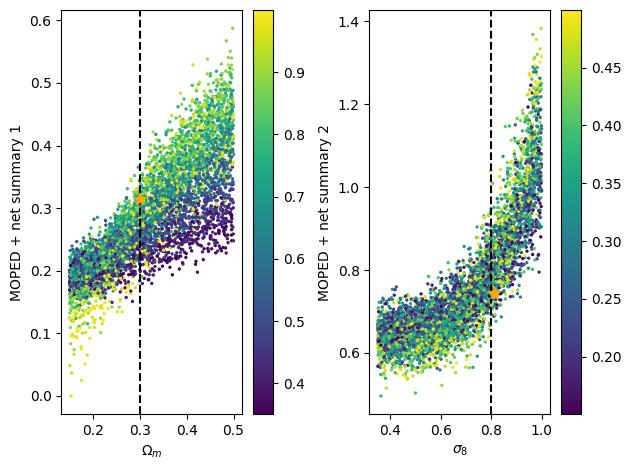

saving everything
-----------------------
RETRAINING FOR NOISEAMP:  0.6
-----------------------
COMPUTING MOPED COMPRESSION FOR N=128, NOISEAMP=0.60, ELL_MIN=0
MINIMUM ELL IDX:  0
NOISEVARS [0.00045021 0.00087473 0.00134725 0.00183411]
SCALED NOISE SIGMAS [0.01273089 0.01774548 0.02202296 0.02569588]


100%|██████████| 60/60 [00:01<00:00, 32.95it/s]


moped 2 F: [[1484.2235 1006.5215]
 [1006.5215  778.8466]] moped 1 F: [[1484.2123  1006.51   ]
 [1006.50574  778.83057]]
moped 2 F: 142897.0 moped 1 F: 142891.75
MOPED F:  [[1484.2123  1006.51   ]
 [1006.50574  778.83057]]
initial IMNN F:  [[2809.346  1377.3231]
 [1377.3231  911.2389]]
initial IMNN_F / MOPED_F : 4.63964
training IMNN now


0it [00:00, ?it/s]

MOPED F:  [[1484.2123  1006.51   ]
 [1006.50574  778.83057]]
final IMNN F:  [[2815.067  1343.295 ]
 [1343.295   869.1648]]
final IMNN_F / MOPED_F : 4.4951186


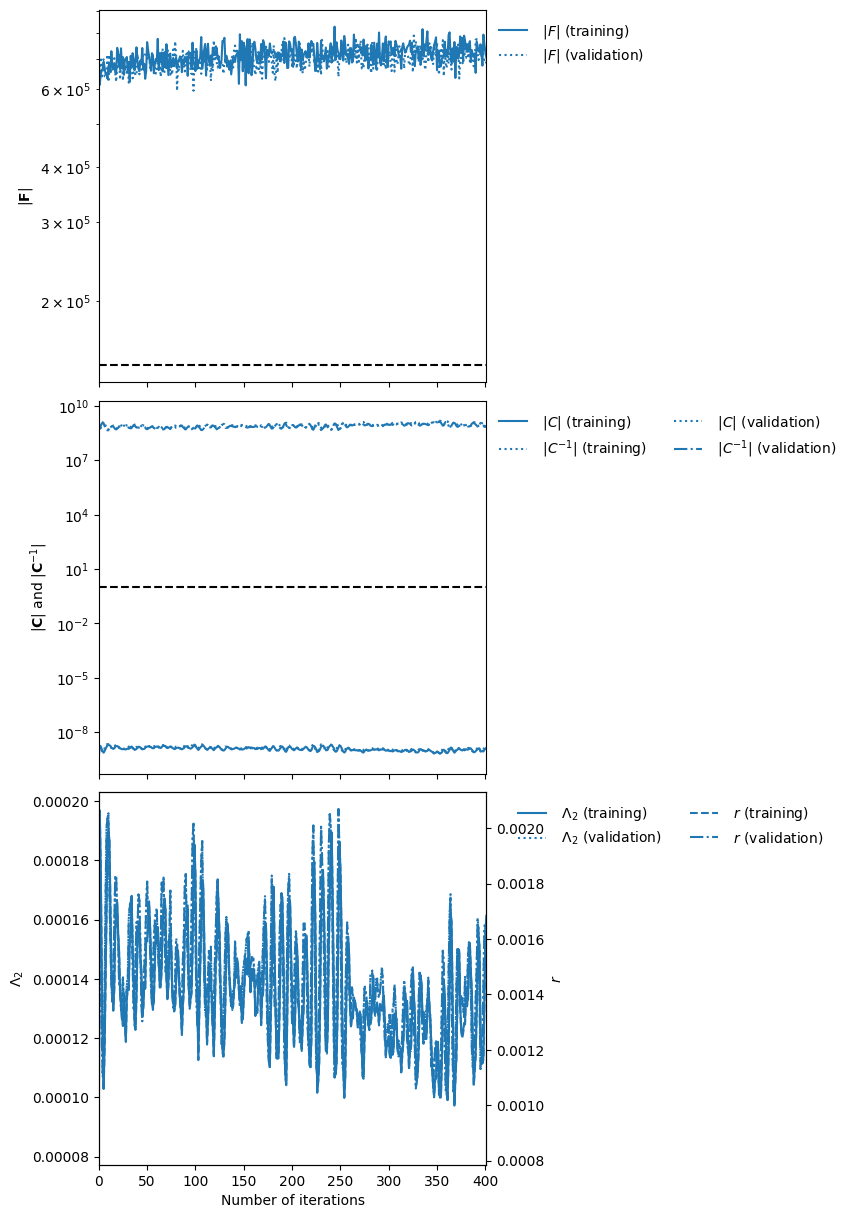

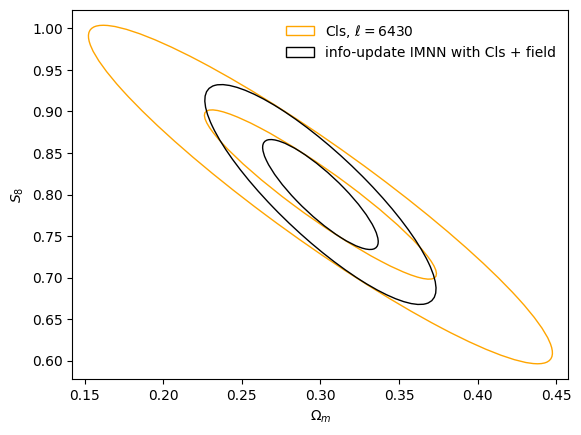

COMPRESSING PRIOR


100%|██████████| 100/100 [00:02<00:00, 45.13it/s]


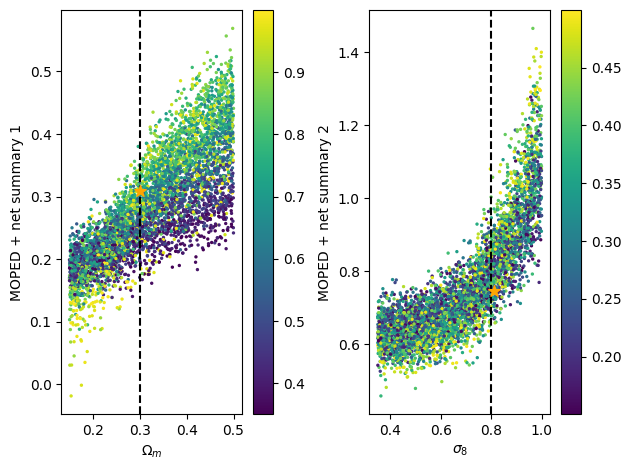

saving everything
-----------------------
RETRAINING FOR NOISEAMP:  0.7
-----------------------
COMPUTING MOPED COMPRESSION FOR N=128, NOISEAMP=0.70, ELL_MIN=0
MINIMUM ELL IDX:  0
NOISEVARS [0.00045021 0.00087473 0.00134725 0.00183411]
SCALED NOISE SIGMAS [0.0148527  0.02070306 0.02569345 0.02997852]


100%|██████████| 60/60 [00:01<00:00, 35.26it/s]


moped 2 F: [[1213.1002   833.5745 ]
 [ 833.57446  645.9513 ]] moped 1 F: [[1213.0886  833.5645]
 [ 833.5614  645.9404]]
moped 2 F: 88757.25 moped 1 F: 88755.81
MOPED F:  [[1213.0886  833.5645]
 [ 833.5614  645.9404]]
initial IMNN F:  [[2391.4158  1198.2568 ]
 [1198.2568   775.29846]]
initial IMNN_F / MOPED_F : 4.7122717
training IMNN now


0it [00:00, ?it/s]

MOPED F:  [[1213.0886  833.5645]
 [ 833.5614  645.9404]]
final IMNN F:  [[2368.5674 1164.9764]
 [1164.9764  739.5304]]
final IMNN_F / MOPED_F : 4.4443007


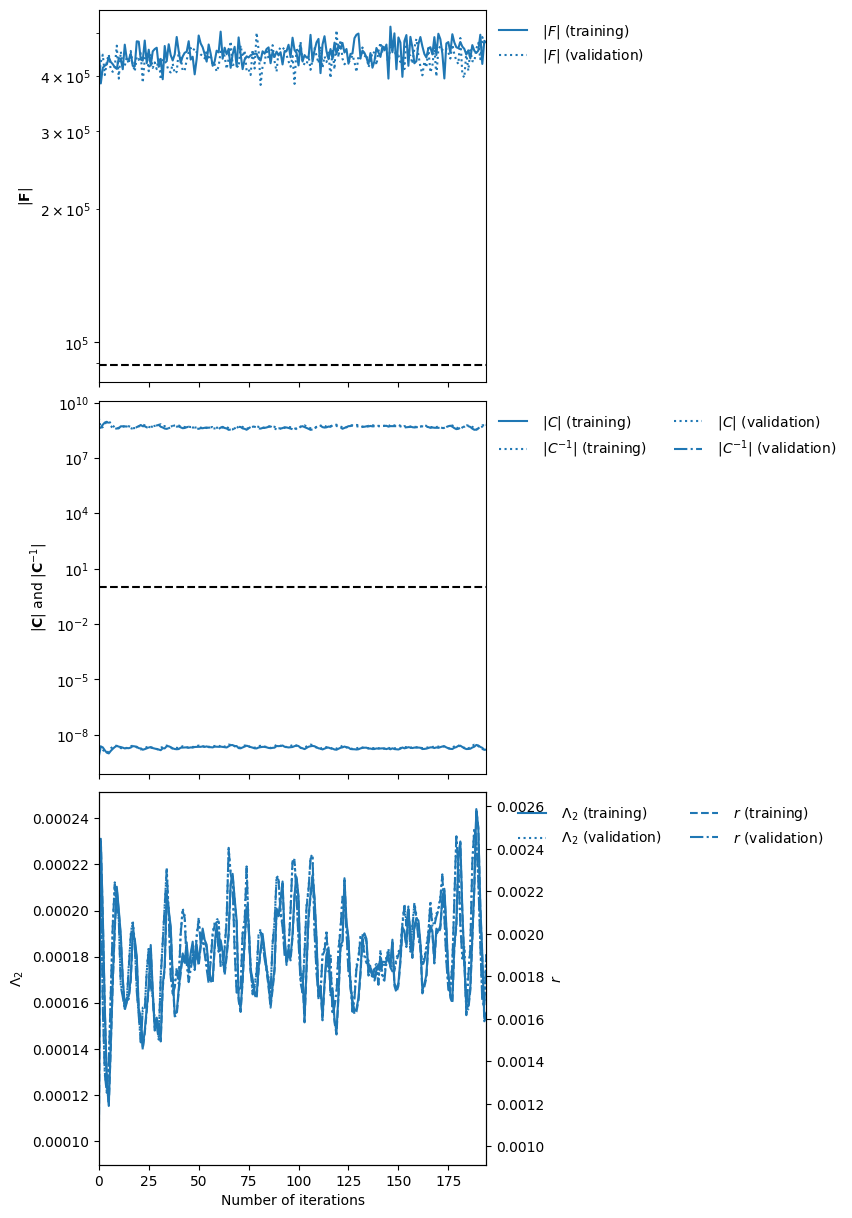

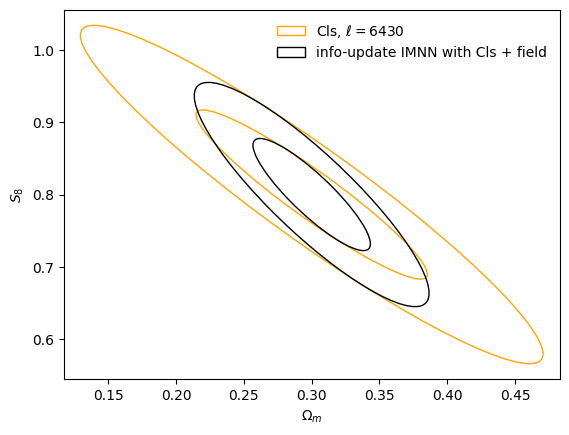

COMPRESSING PRIOR


100%|██████████| 100/100 [00:02<00:00, 45.66it/s]


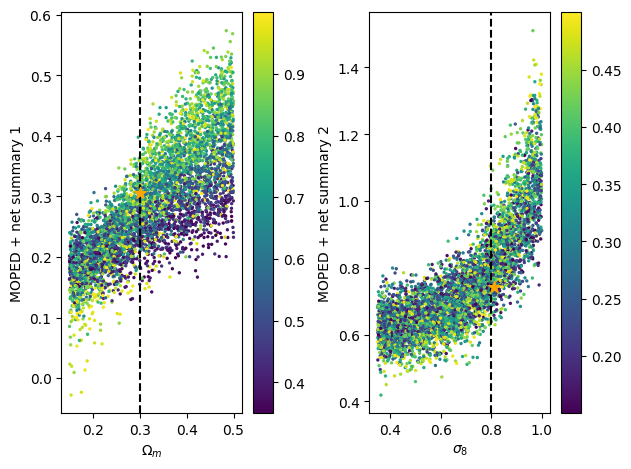

saving everything
-----------------------
RETRAINING FOR NOISEAMP:  0.8
-----------------------
COMPUTING MOPED COMPRESSION FOR N=128, NOISEAMP=0.80, ELL_MIN=0
MINIMUM ELL IDX:  0
NOISEVARS [0.00045021 0.00087473 0.00134725 0.00183411]
SCALED NOISE SIGMAS [0.01697451 0.02366064 0.02936394 0.03426117]


100%|██████████| 60/60 [00:01<00:00, 33.63it/s]


moped 2 F: [[999.1914  694.23956]
 [694.23956 539.62885]] moped 1 F: [[999.17145 694.2223 ]
 [694.21454 539.6067 ]]
moped 2 F: 57223.938 moped 1 F: 57220.406
MOPED F:  [[999.17145 694.2223 ]
 [694.21454 539.6067 ]]
initial IMNN F:  [[1993.8438  1019.6817 ]
 [1019.68176  655.41425]]
initial IMNN_F / MOPED_F : 4.666916
training IMNN now


0it [00:00, ?it/s]

MOPED F:  [[999.17145 694.2223 ]
 [694.21454 539.6067 ]]
final IMNN F:  [[2008.2903  1014.95776]
 [1014.9579   638.6098 ]]
final IMNN_F / MOPED_F : 4.410568


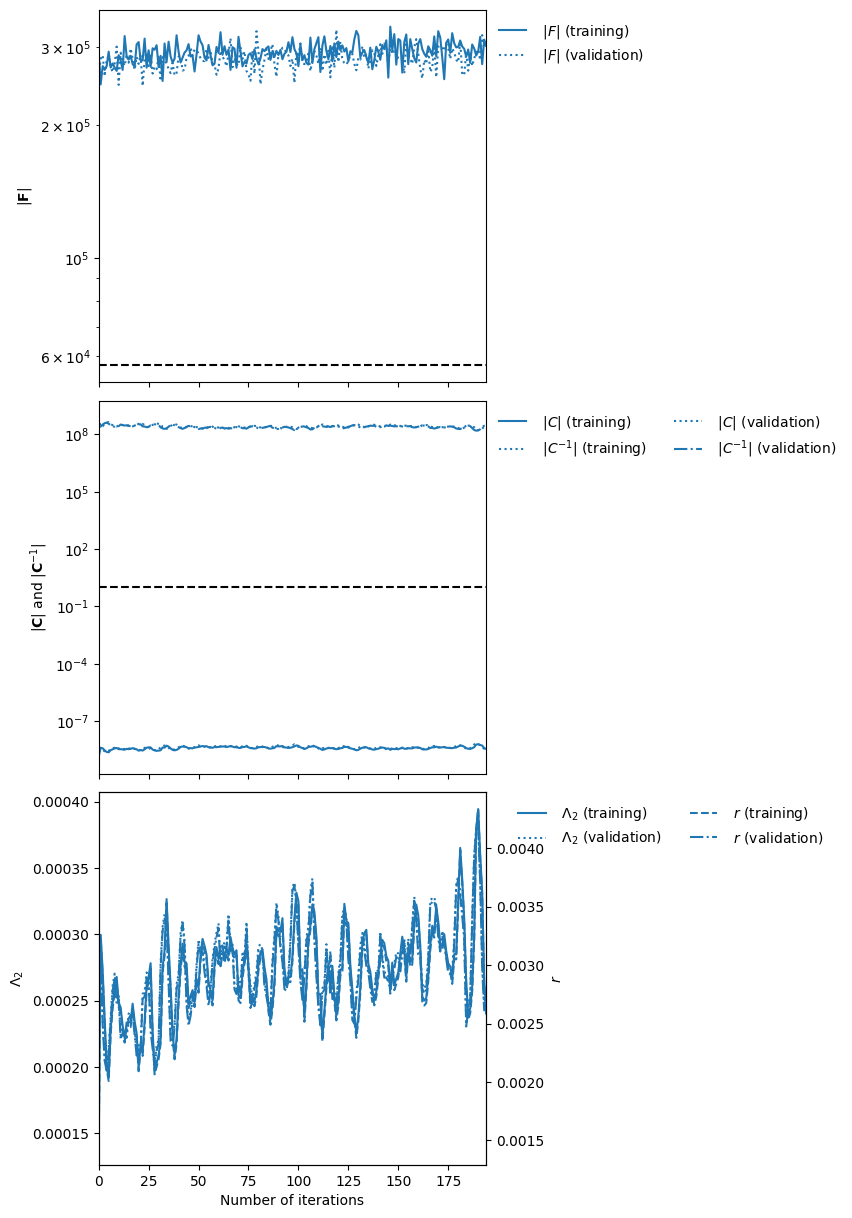

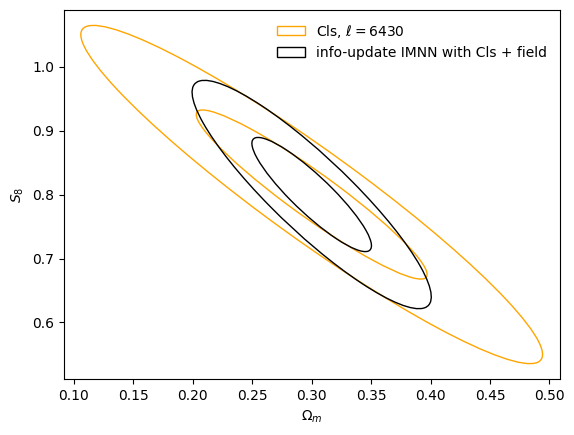

COMPRESSING PRIOR


100%|██████████| 100/100 [00:02<00:00, 47.73it/s]


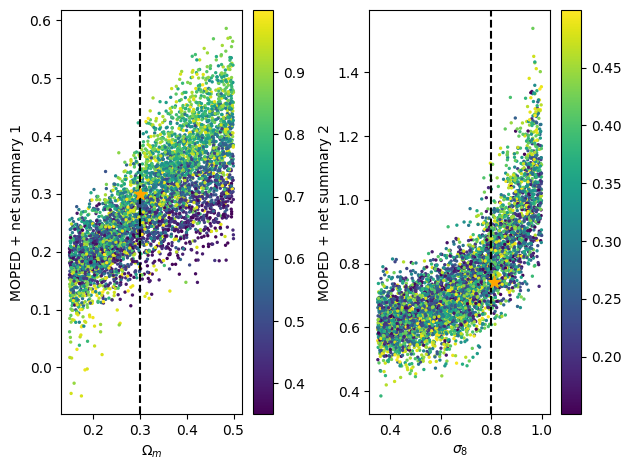

saving everything
-----------------------
RETRAINING FOR NOISEAMP:  0.9
-----------------------
COMPUTING MOPED COMPRESSION FOR N=128, NOISEAMP=0.90, ELL_MIN=0
MINIMUM ELL IDX:  0
NOISEVARS [0.00045021 0.00087473 0.00134725 0.00183411]
SCALED NOISE SIGMAS [0.01909633 0.02661823 0.03303443 0.03854382]


100%|██████████| 60/60 [00:01<00:00, 32.65it/s]


moped 2 F: [[835.8692  586.45953]
 [586.4595  457.77975]] moped 1 F: [[835.8862  586.4759 ]
 [586.48035 457.80026]]
moped 2 F: 38709.25 moped 1 F: 38712.344
MOPED F:  [[835.8862  586.4759 ]
 [586.48035 457.80026]]
initial IMNN F:  [[1707.0056  885.7655]
 [ 885.7655  565.9498]]
initial IMNN_F / MOPED_F : 4.6884027
training IMNN now


0it [00:00, ?it/s]

MOPED F:  [[835.8862  586.4759 ]
 [586.48035 457.80026]]
final IMNN F:  [[1753.1611   903.1261 ]
 [ 903.1261   564.64233]]
final IMNN_F / MOPED_F : 4.501723


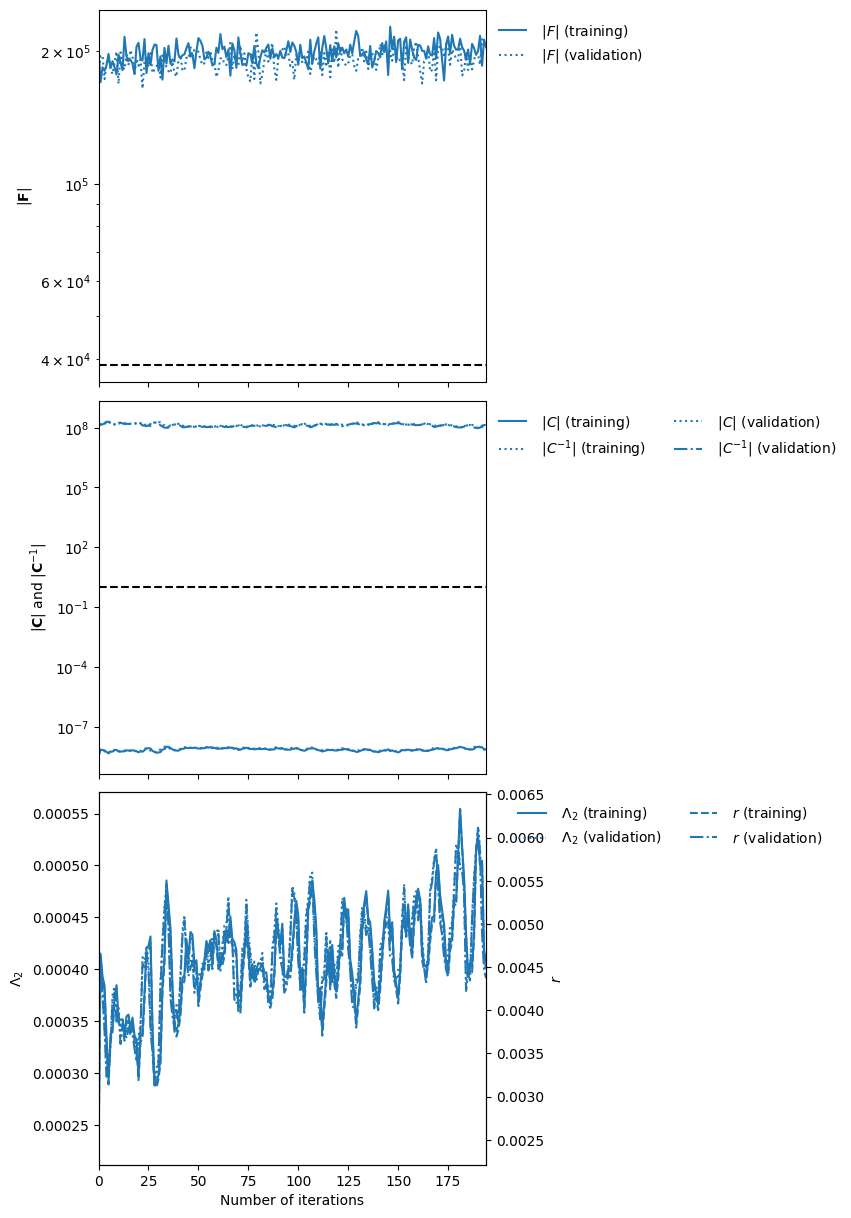

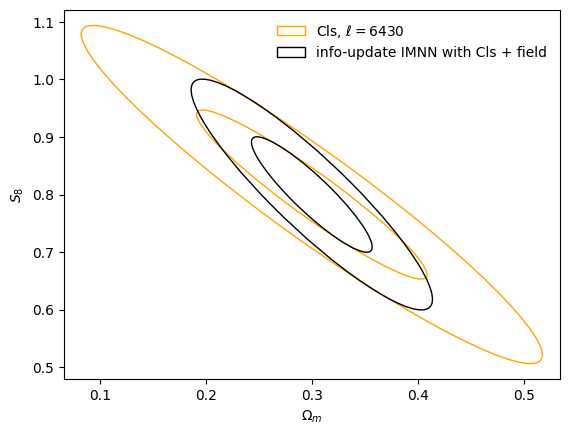

COMPRESSING PRIOR


100%|██████████| 100/100 [00:02<00:00, 46.01it/s]


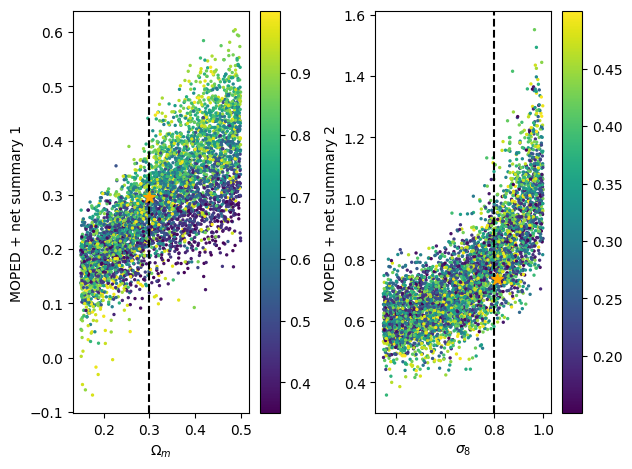

saving everything
-----------------------
RETRAINING FOR NOISEAMP:  1.0
-----------------------
COMPUTING MOPED COMPRESSION FOR N=128, NOISEAMP=1.00, ELL_MIN=0
MINIMUM ELL IDX:  0
NOISEVARS [0.00045021 0.00087473 0.00134725 0.00183411]
SCALED NOISE SIGMAS [0.02121814 0.02957581 0.03670492 0.04282646]


100%|██████████| 60/60 [00:01<00:00, 35.34it/s]


moped 2 F: [[713.03827 504.78143]
 [504.78143 396.03925]] moped 1 F: [[713.0371  504.78055]
 [504.7815  396.03955]]
moped 2 F: 27586.828 moped 1 F: 27587.031
MOPED F:  [[713.0371  504.78055]
 [504.7815  396.03955]]
initial IMNN F:  [[1494.1425   786.28   ]
 [ 786.28     500.99768]]
initial IMNN_F / MOPED_F : 4.7241607
training IMNN now


0it [00:00, ?it/s]

MOPED F:  [[713.0371  504.78055]
 [504.7815  396.03955]]
final IMNN F:  [[1530.7397   805.56067]
 [ 805.5607   505.20923]]
final IMNN_F / MOPED_F : 4.5099387


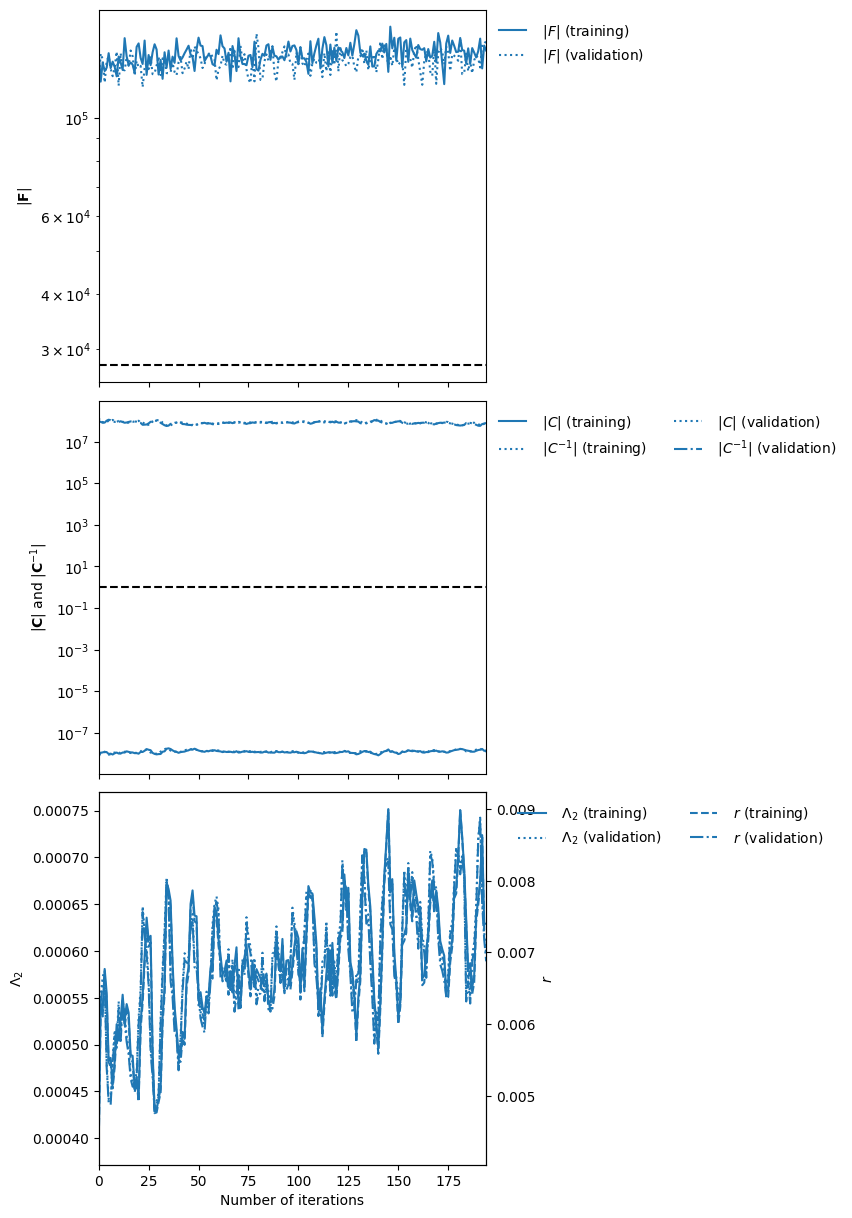

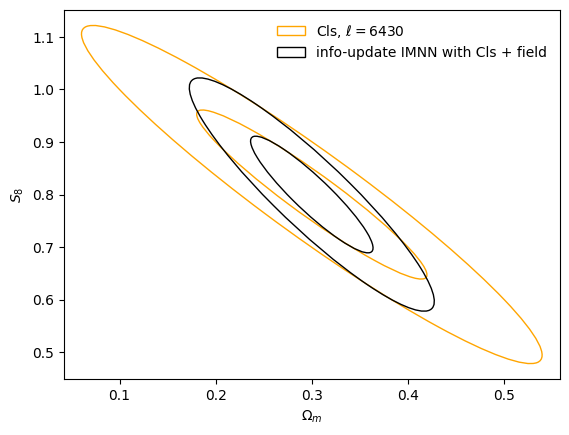

COMPRESSING PRIOR


100%|██████████| 100/100 [00:02<00:00, 47.51it/s]


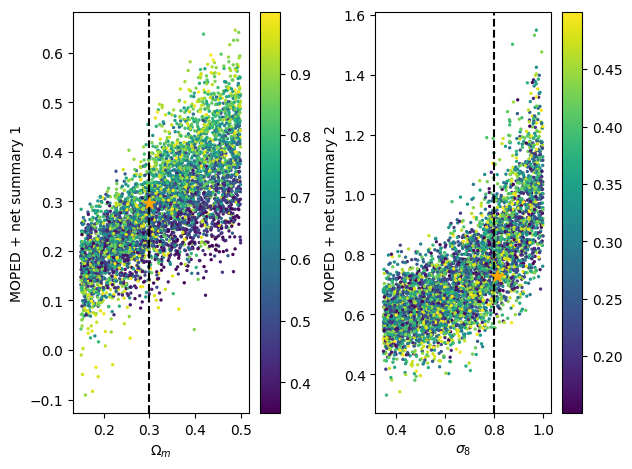

saving everything


In [35]:
# write a loop to slowly increase noise
from fisherplot import *
import gc
gc.collect()

weightdir = "/data101/makinen/lemur_sims/pm_sims/N128/noise_comparison/"
weightfile = "imnn_w_N_%d_2out_low_noise_0.pkl"%(N)

noiseamps = [0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

#weightfile = "imnn_w_N_%d_2out_noise_%d"%(N, noiseamp*100)

# start off the keys
model_key = jr.PRNGKey(44)
key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (4, N, N)

for j,noiseamp in enumerate(noiseamps): 
    
    NOISEAMP = noiseamp
    print("-----------------------")
    print("RETRAINING FOR NOISEAMP: ", noiseamp)
    print("-----------------------")
    
    lr_schedule = optax.exponential_decay(init_value=1e-4, 
                        transition_begin=80,
                        transition_steps=150, 
                        decay_rate=0.5, 
                        end_value=1e-5
                       )
    # --- IMNN STUFF
    # Clip gradients at max value, and evt. apply weight decay
    transf = [optax.clip(1.0)]
    transf.append(optax.add_decayed_weights(1e-4))
    optimiser = optax.chain(
        *transf,
        #optax.sgd(learning_rate=5e-4, momentum=0.9)
        optax.adam(learning_rate=5e-4)
    )
    
    # ---
    
    # insatiate new moped statistic with higher noise settings
    mymoped, moped_stat = get_moped_and_summaries(N=128, noiseamp=NOISEAMP, n_gal=30.)

    # initialise model
    model = MDN_net_stacked(filters=[1,1,1],
                        # rest of network
                        multipole_tomo1 = MPK_layer(multipole_layers=[mpk_layer.build_cnn_model(num_input_filters=f,
                                                                   strides=strides1[i],
                                                                   pad_size=None) for i,f in enumerate(input_filters_rest)],
                                                                   act=act),
                        moped=mymoped,
                        act=act, 
                        n_outs=2
    )


    num_bins = 6
    cl_shape = indices.shape[0]*num_bins

    np = jnp
    # initialise imnn
    IMNN =  newNoiseNumericalGradientIMNN(
        n_s=n_s, n_d=n_d, n_params=n_params, n_summaries=2 + 2,
        input_shape=input_shape, θ_fid=θ_fid, δθ=δθ, model=model,
        optimiser=optimiser, key_or_state=jnp.array(model_key),
        noise_simulator=(lambda rng, d: noise_simulator(
               rng, d, noisescale=NOISEAMP, rot=True)),
        chunk_size=50,
        fiducial=val_fid, 
        derivative=val_derv,
        validation_fiducial=fid,
        validation_derivative=derv,
        existing_statistic=moped_stat,
        no_invC=True, # True
        evidence=True
    )
    # load the previous round's weights
    wbest = load_obj(weightdir + weightfile)
    IMNN.set_F_statistics(wbest, key)
    print("MOPED F: ", mymoped.F)
    print("initial IMNN F: ", IMNN.F)
    print("initial IMNN_F / MOPED_F :", jnp.linalg.det(IMNN.F) / jnp.linalg.det(mymoped.F)) 

    print("training IMNN now")
    key,rng = jax.random.split(key) # retrain # patience=75, min_its=300 
    IMNN.fit(10.0, 0.01, γ=1.0, rng=jnp.array(rng), print_rate=2, patience=75, max_iterations=100000, min_iterations=100) 

    # print and show fishers
    print("MOPED F: ", mymoped.F)
    print("final IMNN F: ", IMNN.F)
    print("final IMNN_F / MOPED_F :", jnp.linalg.det(IMNN.F) / jnp.linalg.det(mymoped.F)) 

    ax = IMNN.plot(expected_detF=jnp.linalg.det(mymoped.F))
    ax[0].set_yscale("log")
    plt.show()

    # new best weights
    weightfile = "imnn_w_N_%d_2out_noise_%d"%(N, noiseamp*100)

    # save the IMNN weights
    save_obj(IMNN.w, weightdir + weightfile)
    weightfile += ".pkl" # add extension

    # -----
    # make a fisher plot
    mean = θ_fid
    fishers = [mymoped.F, IMNN.F]
    colours =["orange", "black", "blue"]
    labels = [r"Cls, $\ell=%d$"%(6430),  "info-update IMNN with Cls + field"]
    
    for i,f in enumerate(fishers): 
        if i==0:
            ax = plot_fisher_ellipse(f, mean=mean, color=colours[i], label=labels[i])
        else:
            plot_fisher_ellipse(f, mean=mean, ax=ax, color=colours[i], label=labels[i])
    
    plt.legend(framealpha=0.0)
    plt.xlabel(r'$\Omega_m$')
    plt.ylabel(r'$S_8$')
    plt.show()
    # -----

    
    print("COMPRESSING PRIOR")
    # pull in all the prior simulations
    prior_sims = jnp.load(outdir + "smaller_prior_S8_L_250_N_%d_Nz_512.npz"%(N))["prior_sims"]
    prior_theta = jnp.load(outdir + "smaller_prior_S8_L_250_N_%d_Nz_512.npz"%(N))["prior_theta"]
    
    def get_sigma8(omegam, S8):
        return S8 / (jnp.sqrt(omegam / 0.3))
    
    def get_S8(theta):
        return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3)]).T

    noisesim = lambda k, d: noise_simulator(k, d, noisescale=noiseamp)
    key = jr.PRNGKey(333)
    noisekeys = jr.split(key, num=prior_sims.shape[0])
    # add in noise
    prior_sims = jax.vmap(noisesim)(noisekeys, prior_sims)

    # now compute Cls 
    prior_cls = []
    batch = 50
    for i in tq(range(prior_sims.shape[0] // batch)):
        f_ = jax.vmap(cls_allbins_nonoise)(prior_sims[i*batch:(i+1)*batch]).reshape(-1, len(indices)*(num_bins))
        prior_cls.append(f_)
    
    prior_cls = jnp.concatenate(prior_cls)
    # compress with moped to get Cls summaries
    moped_summaries = mymoped.compress(prior_cls)

    # get IMNN to compress
    batch = 500 
    outputs = jnp.concatenate([IMNN.get_estimate(prior_sims[i*batch:(i+1)*batch]) for i in range(prior_sims.shape[0] // batch)])

    # load target
    target = jnp.load(outdir + "target_L_%d_N_%d_Nz_512.npz"%(L, N))["kappa"]
    target_theta = jnp.load(outdir + "target_L_%d_N_%d_Nz_512.npz"%(L, N))["theta"]
    
    noise_target_key = jax.random.PRNGKey(604)
    noisy_target = noisesim(noise_target_key, target)
    network_target = IMNN.get_estimate(noisy_target[jnp.newaxis, ...])
    moped_target = mymoped.compress(cls_allbins_nonoise(noisy_target).reshape(-1, len(indices)*(num_bins)))

    # plot summaries
    plt.subplot(121)
    im = plt.scatter(prior_theta[:, 0], outputs[:, 0], s=2, c=prior_theta[:, 1])
    plt.axvline(θ_fid[0], c="k", ls="--")
    plt.scatter(target_theta[0], network_target[:, 0], c="orange", marker="*", s=74, zorder=23)
    
    plt.xlabel(r"$\Omega_m$")
    plt.ylabel(r"MOPED + net summary 1")
    plt.colorbar(im)
    
    plt.subplot(122)
    im = plt.scatter(prior_theta[:, 1], outputs[:, 1], s=2, c=prior_theta[:, 0])
    plt.axvline(θ_fid[1], c="k", ls="--")
    plt.scatter(target_theta[1], network_target[:, 1], c="orange", marker="*", s=74, zorder=23)
    plt.ylabel(r"MOPED + net summary 2")
    plt.xlabel(r"$\sigma_8$")
    plt.colorbar(im)
    plt.tight_layout()

    plt.show()
    
    print("saving everything")
    np.savez("N128_noisy/summaries_noise_%d"%(noiseamp * 100),
             moped_summaries=moped_summaries,
             prior_theta=prior_theta,
             network_outputs=outputs,
             target=target,
             noisy_target=noisy_target,
             target_theta=target_theta,
             network_target=network_target,
             moped_target=moped_target
            )
    gc.collect()


-----------------------
RETRAINING FOR NOISEAMP:  0.5
-----------------------
COMPUTING MOPED COMPRESSION FOR N=128, NOISEAMP=0.50, ELL_MIN=0
MINIMUM ELL IDX:  0


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


NOISEVARS [0.00045021 0.00087473 0.00134725 0.00183411]
SCALED NOISE SIGMAS [0.01060907 0.0147879  0.01835246 0.02141323]


100%|██████████| 60/60 [00:01<00:00, 34.54it/s]


moped 2 F: [[1812.0869 1208.6853]
 [1208.6853  936.6779]] moped 1 F: [[1812.1118 1208.7076]
 [1208.7104  936.7003]]
moped 2 F: 236421.62 moped 1 F: 236428.25
MOPED F:  [[1812.1118 1208.7076]
 [1208.7104  936.7003]]
initial IMNN F:  [[3698.2256 1654.9551]
 [1654.9551 1064.87  ]]
initial IMNN_F / MOPED_F : 5.0723777
training IMNN now


0it [00:00, ?it/s]

MOPED F:  [[1812.1118 1208.7076]
 [1208.7104  936.7003]]
final IMNN F:  [[3681.419  1658.204 ]
 [1658.2041 1068.8569]]
final IMNN_F / MOPED_F : 5.0132318


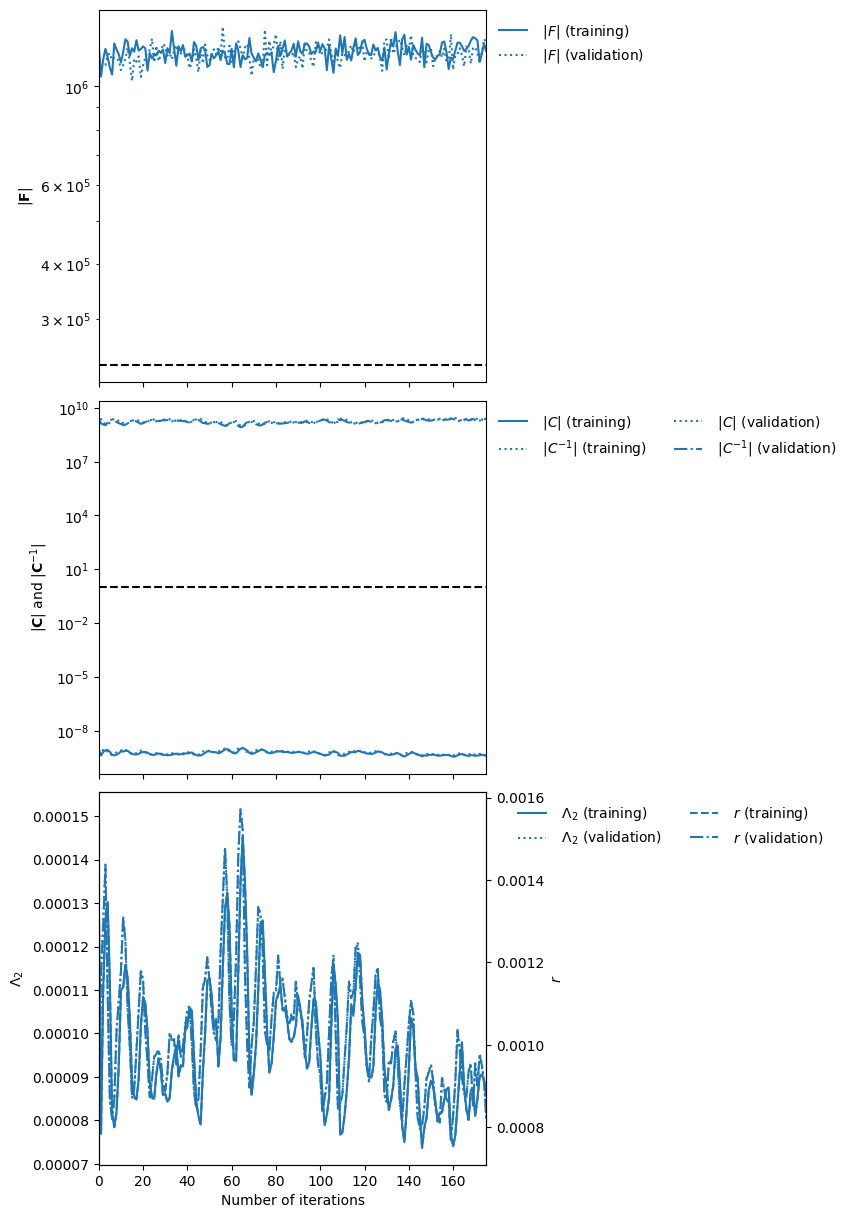

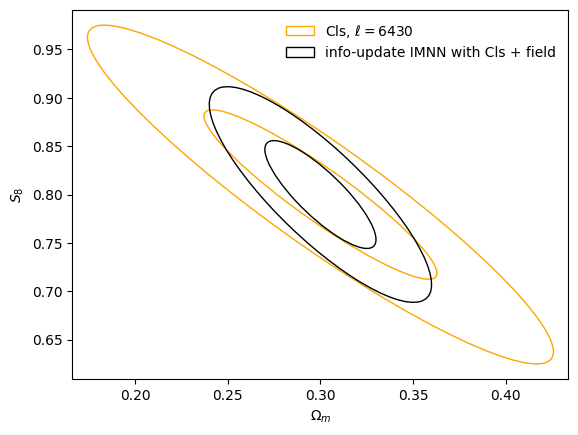

COMPRESSING PRIOR


100%|██████████| 100/100 [00:02<00:00, 47.90it/s]


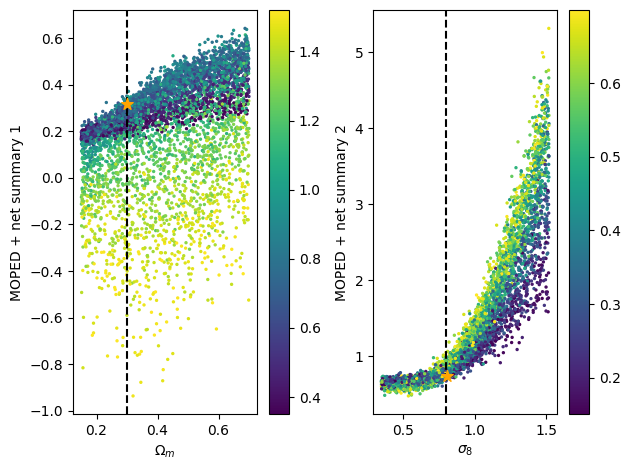

saving everything


In [38]:
# write a loop to slowly increase noise
from fisherplot import *
import gc
gc.collect()

weightdir = "/data101/makinen/lemur_sims/pm_sims/N128/noise_comparison/"
weightfile = "imnn_w_N_128_2out_noise_50_3.pkl" #"imnn_w_N_%d_2out_low_noise_0.pkl"%(N)

noiseamps = [0.5]

#weightfile = "imnn_w_N_%d_2out_noise_%d"%(N, noiseamp*100)

# start off the keys
model_key = jr.PRNGKey(44)
key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (4, N, N)

for j,noiseamp in enumerate(noiseamps): 
    
    NOISEAMP = noiseamp
    print("-----------------------")
    print("RETRAINING FOR NOISEAMP: ", noiseamp)
    print("-----------------------")
    
    lr_schedule = optax.exponential_decay(init_value=1e-4, 
                        transition_begin=80,
                        transition_steps=150, 
                        decay_rate=0.5, 
                        end_value=1e-5
                       )
    # --- IMNN STUFF
    # Clip gradients at max value, and evt. apply weight decay
    transf = [optax.clip(1.0)]
    transf.append(optax.add_decayed_weights(1e-4))
    optimiser = optax.chain(
        *transf,
        #optax.sgd(learning_rate=5e-4, momentum=0.9)
        optax.adam(learning_rate=5e-4)
    )
    
    # ---
    
    # insatiate new moped statistic with higher noise settings
    mymoped, moped_stat = get_moped_and_summaries(N=128, noiseamp=NOISEAMP, n_gal=30.)

    # initialise model
    model = MDN_net_stacked(filters=[1,1,1],
                        # rest of network
                        multipole_tomo1 = MPK_layer(multipole_layers=[mpk_layer.build_cnn_model(num_input_filters=f,
                                                                   strides=strides1[i],
                                                                   pad_size=None) for i,f in enumerate(input_filters_rest)],
                                                                   act=act),
                        moped=mymoped,
                        act=act, 
                        n_outs=2
    )


    num_bins = 6
    cl_shape = indices.shape[0]*num_bins

    np = jnp
    # initialise imnn
    IMNN =  newNoiseNumericalGradientIMNN(
        n_s=n_s, n_d=n_d, n_params=n_params, n_summaries=2 + 2,
        input_shape=input_shape, θ_fid=θ_fid, δθ=δθ, model=model,
        optimiser=optimiser, key_or_state=jnp.array(model_key),
        noise_simulator=(lambda rng, d: noise_simulator(
               rng, d, noisescale=NOISEAMP, rot=True)),
        chunk_size=50,
        fiducial=val_fid, 
        derivative=val_derv,
        validation_fiducial=fid,
        validation_derivative=derv,
        existing_statistic=moped_stat,
        no_invC=True, # True
        evidence=True
    )
    # load the previous round's weights
    wbest = load_obj(weightdir + weightfile)
    IMNN.set_F_statistics(wbest, key)
    print("MOPED F: ", mymoped.F)
    print("initial IMNN F: ", IMNN.F)
    print("initial IMNN_F / MOPED_F :", jnp.linalg.det(IMNN.F) / jnp.linalg.det(mymoped.F)) 

    print("training IMNN now")
    key,rng = jax.random.split(key) # retrain # patience=75, min_its=300 
    IMNN.fit(10.0, 0.01, γ=1.0, rng=jnp.array(rng), print_rate=2, patience=75, max_iterations=100000, min_iterations=100) 

    # print and show fishers
    print("MOPED F: ", mymoped.F)
    print("final IMNN F: ", IMNN.F)
    print("final IMNN_F / MOPED_F :", jnp.linalg.det(IMNN.F) / jnp.linalg.det(mymoped.F)) 

    ax = IMNN.plot(expected_detF=jnp.linalg.det(mymoped.F))
    ax[0].set_yscale("log")
    plt.show()

    # new best weights
    weightfile = "imnn_w_N_%d_2out_noise_%d_4"%(N, noiseamp*100)

    # save the IMNN weights
    save_obj(IMNN.w, weightdir + weightfile)
    weightfile += ".pkl" # add extension

    # -----
    # make a fisher plot
    mean = θ_fid
    fishers = [mymoped.F, IMNN.F]
    colours =["orange", "black", "blue"]
    labels = [r"Cls, $\ell=%d$"%(6430),  "info-update IMNN with Cls + field"]
    
    for i,f in enumerate(fishers): 
        if i==0:
            ax = plot_fisher_ellipse(f, mean=mean, color=colours[i], label=labels[i])
        else:
            plot_fisher_ellipse(f, mean=mean, ax=ax, color=colours[i], label=labels[i])
    
    plt.legend(framealpha=0.0)
    plt.xlabel(r'$\Omega_m$')
    plt.ylabel(r'$S_8$')
    plt.show()
    # -----

    
    print("COMPRESSING PRIOR")
    # pull in all the prior simulations
    prior_sims = jnp.load(outdir + "prior_S8_L_250_N_%d_Nz_512.npz"%(N))["prior_sims"]
    prior_theta = jnp.load(outdir + "prior_S8_L_250_N_%d_Nz_512.npz"%(N))["prior_theta"]
    
    def get_sigma8(omegam, S8):
        return S8 / (jnp.sqrt(omegam / 0.3))
    
    def get_S8(theta):
        return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3)]).T

    noisesim = lambda k, d: noise_simulator(k, d, noisescale=noiseamp)
    key = jr.PRNGKey(333)
    noisekeys = jr.split(key, num=prior_sims.shape[0])
    # add in noise
    prior_sims = jax.vmap(noisesim)(noisekeys, prior_sims)

    # now compute Cls 
    prior_cls = []
    batch = 50
    for i in tq(range(prior_sims.shape[0] // batch)):
        f_ = jax.vmap(cls_allbins_nonoise)(prior_sims[i*batch:(i+1)*batch]).reshape(-1, len(indices)*(num_bins))
        prior_cls.append(f_)
    
    prior_cls = jnp.concatenate(prior_cls)
    # compress with moped to get Cls summaries
    moped_summaries = mymoped.compress(prior_cls)

    # get IMNN to compress
    batch = 500 
    outputs = jnp.concatenate([IMNN.get_estimate(prior_sims[i*batch:(i+1)*batch]) for i in range(prior_sims.shape[0] // batch)])

    # load target
    target = jnp.load(outdir + "target_L_%d_N_%d_Nz_512.npz"%(L, N))["kappa"]
    target_theta = jnp.load(outdir + "target_L_%d_N_%d_Nz_512.npz"%(L, N))["theta"]
    
    noise_target_key = jax.random.PRNGKey(604)
    noisy_target = noisesim(noise_target_key, target)
    network_target = IMNN.get_estimate(noisy_target[jnp.newaxis, ...])
    moped_target = mymoped.compress(cls_allbins_nonoise(noisy_target).reshape(-1, len(indices)*(num_bins)))

    # plot summaries
    plt.subplot(121)
    im = plt.scatter(prior_theta[:, 0], outputs[:, 0], s=2, c=prior_theta[:, 1])
    plt.axvline(θ_fid[0], c="k", ls="--")
    plt.scatter(target_theta[0], network_target[:, 0], c="orange", marker="*", s=74, zorder=23)
    
    plt.xlabel(r"$\Omega_m$")
    plt.ylabel(r"MOPED + net summary 1")
    plt.colorbar(im)
    
    plt.subplot(122)
    im = plt.scatter(prior_theta[:, 1], outputs[:, 1], s=2, c=prior_theta[:, 0])
    plt.axvline(θ_fid[1], c="k", ls="--")
    plt.scatter(target_theta[1], network_target[:, 1], c="orange", marker="*", s=74, zorder=23)
    plt.ylabel(r"MOPED + net summary 2")
    plt.xlabel(r"$\sigma_8$")
    plt.colorbar(im)
    plt.tight_layout()

    plt.show()
    
    print("saving everything")
    np.savez("N128_noisy/summaries_noise_%d_bigprior"%(noiseamp * 100),
             moped_summaries=moped_summaries,
             prior_theta=prior_theta,
             network_outputs=outputs,
             target=target,
             noisy_target=noisy_target,
             target_theta=target_theta,
             network_target=network_target,
             moped_target=moped_target
            )
    gc.collect()


In [106]:
key,rng = jax.random.split(key) # retrain # patience=75, min_its=300 
IMNN.fit(10.0, 0.01, γ=1.0, rng=jnp.array(rng), print_rate=2, patience=75, max_iterations=100000, min_iterations=300) # patience=200

0it [00:00, ?it/s]

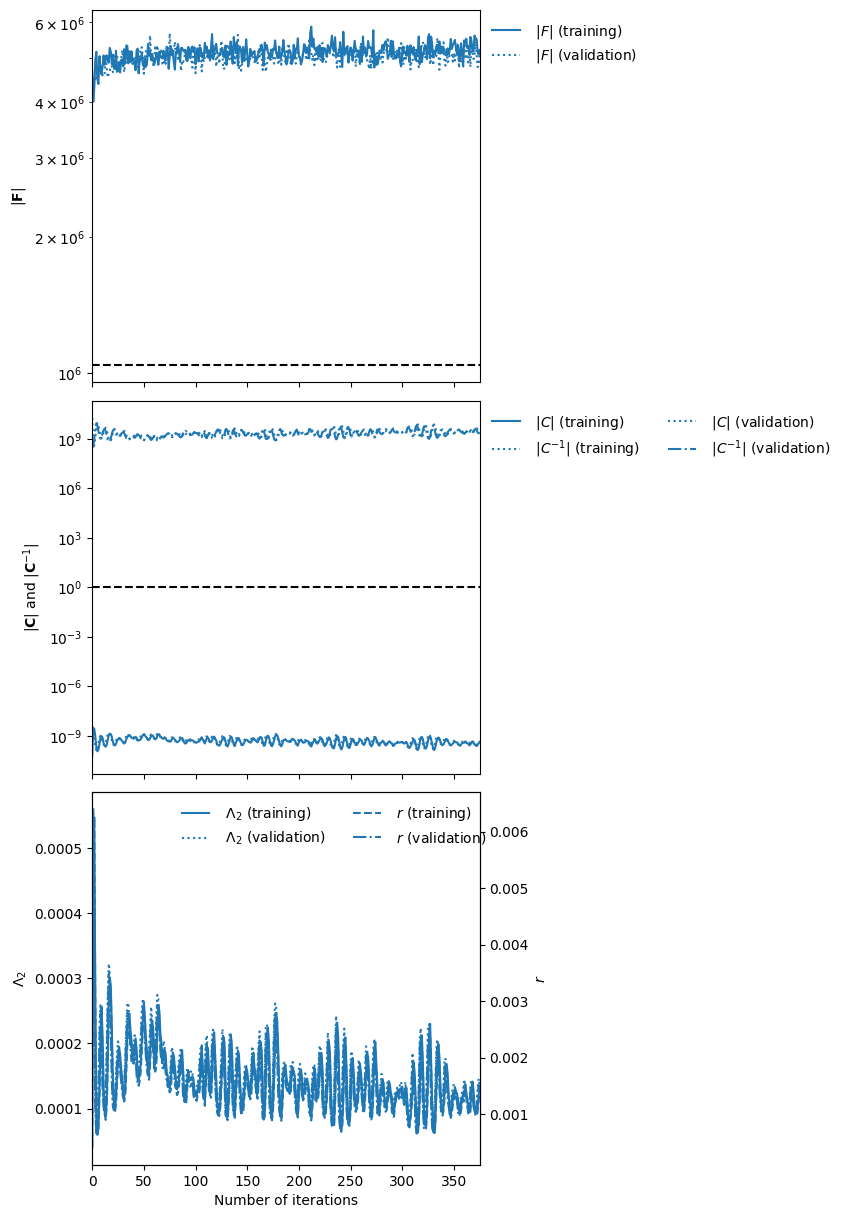

In [107]:
ax = IMNN.plot(expected_detF=jnp.linalg.det(mymoped.F))
ax[0].set_yscale("log")

In [65]:
save_obj(IMNN.w, outdir + "imnn_w_N_%d_2out_low_noise_0"%(N))

In [108]:
# end of training
IMNN.F, mymoped.F

(Array([[6567.273 , 2342.62  ],
        [2342.6204, 1628.4651]], dtype=float32),
 Array([[2824.47  , 1762.2112],
        [1762.1864, 1467.4973]], dtype=float32))

In [109]:
jnp.linalg.det(IMNN.F)

Array(5206705.5, dtype=float32)

In [110]:
jnp.linalg.det(IMNN.F) / jnp.linalg.det(mymoped.F)

Array(5.008579, dtype=float32)

In [143]:
ell[:cl_cut]

Array([ 100.43279,  200.86559,  301.29837,  401.73117,  502.16397,
        602.5968 ,  703.02954,  803.46234,  903.89514, 1004.3279 ,
       1104.7607 , 1205.1936 , 1305.6262 , 1406.0591 , 1506.492  ,
       1606.9247 , 1707.3574 , 1807.7903 , 1908.2231 , 2008.6559 ,
       2109.0886 , 2209.5215 , 2309.954  , 2410.3872 , 2510.8198 ,
       2611.2524 , 2711.6855 , 2812.1182 , 2912.5508 , 3012.984  ,
       3113.4165 , 3213.8494 , 3314.2822 , 3414.7148 , 3515.148  ,
       3615.5806 , 3716.0132 , 3816.4463 , 3916.879  , 4017.3115 ,
       4117.7446 , 4218.1772 , 4318.6104 , 4419.043  , 4519.4756 ,
       4619.908  , 4720.3413 , 4820.774  , 4921.207  , 5021.6396 ,
       5122.0723 , 5222.5054 , 5322.938  , 5423.371  , 5523.8037 ,
       5624.2363 , 5724.669  , 5825.102  , 5925.5347 , 6025.968  ,
       6126.4004 , 6226.833  , 6327.2656 ], dtype=float32)

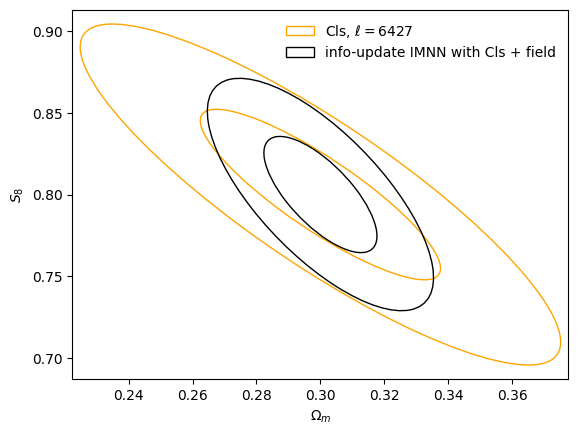

In [113]:
mean = θ_fid
fishers = [mymoped.F, IMNN.F]
colours =["orange", "black", "blue"]
labels = [r"Cls, $\ell=%d$"%(6430),  "info-update IMNN with Cls + field"]

for i,f in enumerate(fishers): 
    if i==0:
        ax = plot_fisher_ellipse(f, mean=mean, color=colours[i], label=labels[i])
    else:
        plot_fisher_ellipse(f, mean=mean, ax=ax, color=colours[i], label=labels[i])

plt.legend(framealpha=0.0)
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$S_8$')
plt.show()

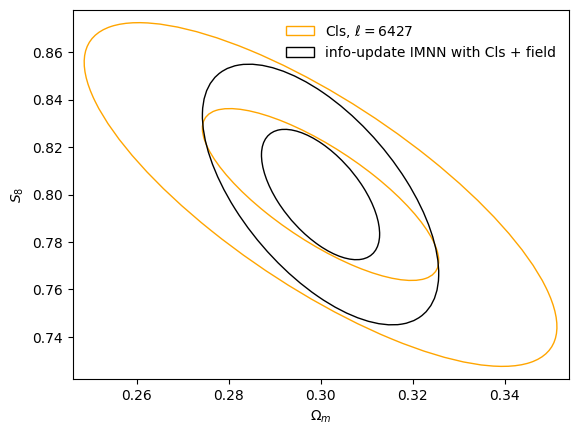

In [40]:
mean = θ_fid # Example mean vector

fishers = [mymoped.F, IMNN.F]
colours =["orange", "black", "blue"]
labels = [r"Cls, $\ell=%d$"%(ell[cl_cut]),  "info-update IMNN with Cls + field"]

for i,f in enumerate(fishers): 
    if i==0:
        ax = plot_fisher_ellipse(f, mean=mean, color=colours[i], label=labels[i])
    else:
        plot_fisher_ellipse(f, mean=mean, ax=ax, color=colours[i], label=labels[i])

plt.legend(framealpha=0.0)

plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$S_8$')
#plt.title('Fisher Information Matrix Ellipse')

#plt.grid(True)
plt.show()

In [1]:
outdir

NameError: name 'outdir' is not defined

In [115]:
# pull in prior 
num = 5000

# prior_sims = jnp.load(outdir + "prior_S8_L_250_N_128_Nz_512_LPT2.npz")["prior_sims"][:num]
# prior_theta = jnp.load(outdir + "prior_S8_L_250_N_128_Nz_512_LPT2.npz")["prior_theta"][:num]

prior_sims = jnp.load(outdir + "smaller_prior_S8_L_%d_N_128_Nz_512.npz"%(L))["prior_sims"][:num]
prior_theta = jnp.load(outdir + "smaller_prior_S8_L_%d_N_128_Nz_512.npz"%(L))["prior_theta"][:num]

def get_sigma8(omegam, S8):
    return S8 / (jnp.sqrt(omegam / 0.3))

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3)]).T


In [44]:
#prior_theta = get_S8(prior_theta)

In [116]:
key = jr.PRNGKey(333)
noisekeys = jr.split(key, num=prior_sims.shape[0])

# add in noise
prior_sims = jax.vmap(noise_simulator)(noisekeys, prior_sims)

In [117]:
# now compute Cls 

# ----- DO MOPED WITH ALL SIMS (NOISEFREE) -----
prior_cls = []
batch = 50
for i in tq(range(prior_sims.shape[0] // batch)):
    f_ = jax.vmap(cls_allbins_nonoise)(prior_sims[i*batch:(i+1)*batch]).reshape(-1, len(indices)*(num_bins))
    prior_cls.append(f_)

prior_cls = jnp.concatenate(prior_cls)

100%|██████████| 100/100 [00:01<00:00, 52.39it/s]


In [118]:
prior_cls.shape

(5000, 60)

In [119]:
# compress with moped to get Cls summaries
moped_summaries = mymoped.compress(prior_cls)

In [120]:
batch = 500

outputs = jnp.concatenate([IMNN.get_estimate(prior_sims[i*batch:(i+1)*batch]) for i in range(prior_sims.shape[0] // batch)])

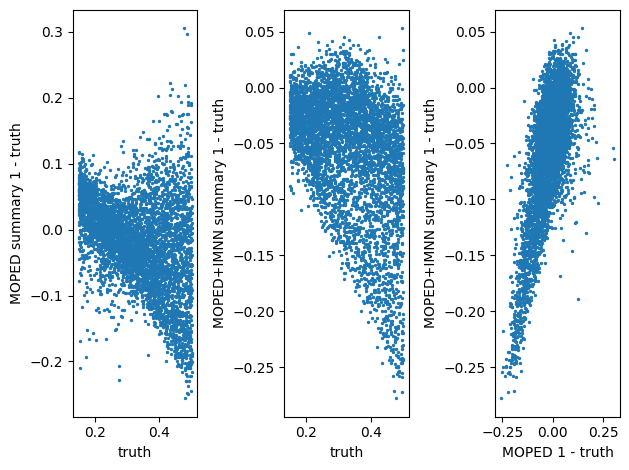

In [121]:
plt.subplot(131)
plt.scatter(prior_theta[:, 0], moped_summaries[:, 0] - prior_theta[:, 0], s=2)#, c=prior_theta[:, 1])
plt.xlabel(r"truth")
plt.ylabel(r"MOPED summary 1 - truth")

plt.subplot(132)
plt.scatter(prior_theta[:, 0], outputs[:, 0] - prior_theta[:, 0], s=2)
plt.ylabel(r"MOPED+IMNN summary 1 - truth")
plt.xlabel(r"truth")

plt.subplot(133)
plt.scatter((moped_summaries[:, 0] - prior_theta[:, 0]), outputs[:, 0] - prior_theta[:, 0], s=2)
plt.ylabel(r"MOPED+IMNN summary 1 - truth")
plt.xlabel(r"MOPED 1 - truth")

            
plt.tight_layout()

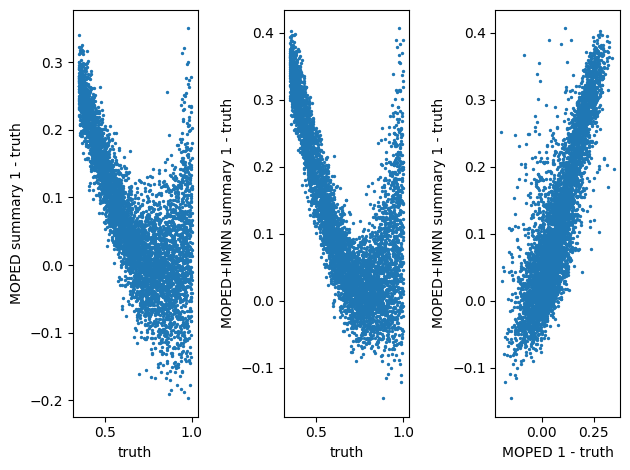

In [122]:
plt.subplot(131)
param = 1

plt.scatter(prior_theta[:, param], moped_summaries[:, param] - prior_theta[:, param], s=2)#, c=prior_theta[:, 1])
plt.xlabel(r"truth")
plt.ylabel(r"MOPED summary 1 - truth")

plt.subplot(132)
plt.scatter(prior_theta[:, param], outputs[:, param] - prior_theta[:, param], s=2)
plt.ylabel(r"MOPED+IMNN summary 1 - truth")
plt.xlabel(r"truth")

plt.subplot(133)
plt.scatter((moped_summaries[:, param] - prior_theta[:, param]), outputs[:, param] - prior_theta[:, param], s=2)
plt.ylabel(r"MOPED+IMNN summary 1 - truth")
plt.xlabel(r"MOPED 1 - truth")

            
plt.tight_layout()

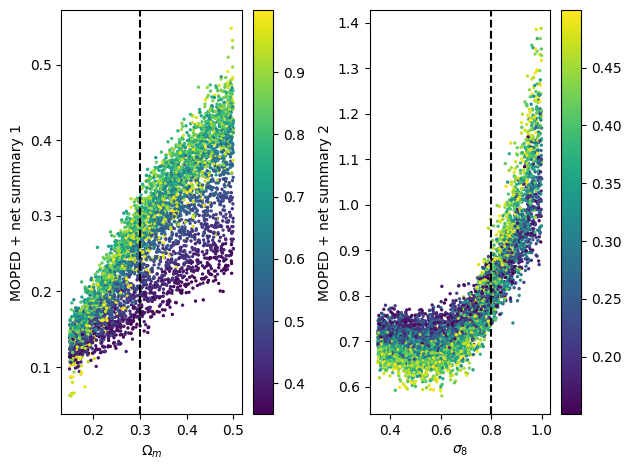

In [123]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], outputs[:, 0], s=2, c=prior_theta[:, 1])
plt.axvline(θ_fid[0], c="k", ls="--")
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"MOPED + net summary 1")
plt.colorbar()

plt.subplot(122)
plt.scatter(prior_theta[:, 1], outputs[:, 1], s=2, c=prior_theta[:, 0])
plt.axvline(θ_fid[1], c="k", ls="--")
plt.ylabel(r"MOPED + net summary 2")
plt.xlabel(r"$\sigma_8$")
plt.colorbar()

plt.tight_layout()

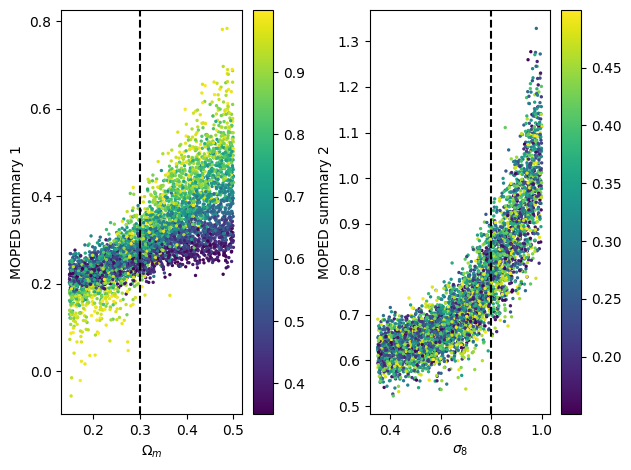

In [125]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], moped_summaries[:, 0], s=2, c=prior_theta[:, 1])
plt.axvline(θ_fid[0], c="k", ls="--")
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"MOPED summary 1")
plt.colorbar()

plt.subplot(122)
plt.scatter(prior_theta[:, 1], moped_summaries[:, 1], s=2, c=prior_theta[:, 0])
plt.axvline(0.8, c="k", ls="--")
plt.ylabel(r"MOPED summary 2")
plt.xlabel(r"$\sigma_8$")
plt.colorbar()

plt.tight_layout()

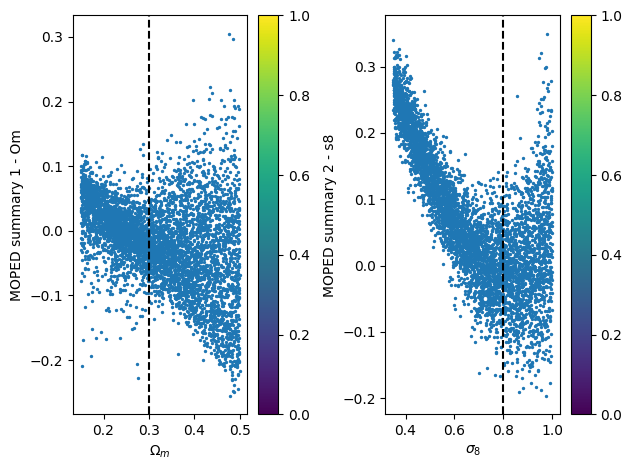

In [126]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], moped_summaries[:, 0] - prior_theta[:, 0], s=2)#, c=neural_summaries[:, 1])
plt.axvline(0.3, c="k", ls="--")

plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"MOPED summary 1 - Om")
plt.colorbar()

plt.subplot(122)
plt.scatter(prior_theta[:, 1], moped_summaries[:, 1] - prior_theta[:, 1], s=2 )#, c=neural_summaries[:, 0])
plt.axvline(0.8, c="k", ls="--")
plt.ylabel(r"MOPED summary 2 - s8")
plt.xlabel(r"$\sigma_8$")
plt.colorbar()


plt.tight_layout()

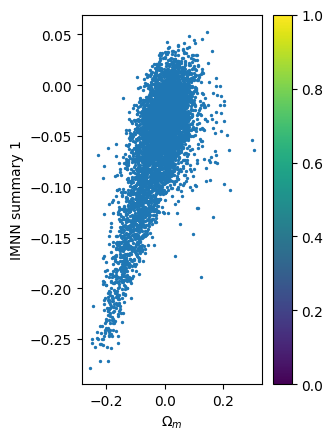

In [127]:
plt.subplot(121)
plt.scatter(moped_summaries[:, 0] - prior_theta[:, 0], outputs[:, 0] - prior_theta[:, 0], s=2)#, c=neural_summaries[:, 1])
#plt.axvline(0.3, c="k", ls="--")

plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"IMNN summary 1")
plt.colorbar()

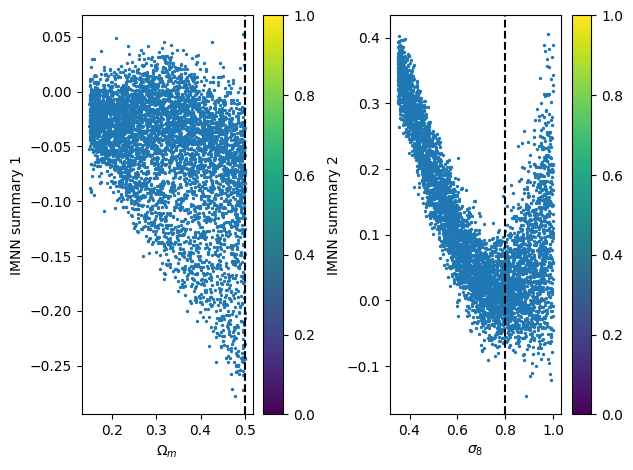

In [128]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], outputs[:, 0] - prior_theta[:, 0], s=2)#, c=neural_summaries[:, 1])
plt.axvline(0.5, c="k", ls="--")

plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"IMNN summary 1")
plt.colorbar()

plt.subplot(122)
plt.scatter(prior_theta[:, 1], outputs[:, 1] - prior_theta[:, 1], s=2 )#, c=neural_summaries[:, 0])
plt.axvline(0.8, c="k", ls="--")
plt.ylabel(r"IMNN summary 2")
plt.xlabel(r"$\sigma_8$")
plt.colorbar()


plt.tight_layout()

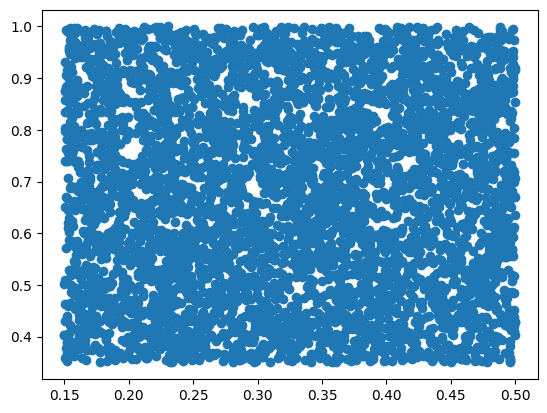

In [129]:
plt.scatter(prior_theta[:, 0], prior_theta[:, 1])

In [130]:
target = jnp.load(outdir + "target_L_%d_N_%d_Nz_512.npz"%(L, N))["kappa"]
target_theta = jnp.load(outdir + "target_L_%d_N_%d_Nz_512.npz"%(L, N))["theta"]

In [131]:
#target = fid[99]

In [132]:
target = jnp.load(outdir + "target_L_%d_N_%d_Nz_512.npz"%(L, N))["kappa"]
target_theta = jnp.load(outdir + "target_L_%d_N_%d_Nz_512.npz"%(L, N))["theta"]

noise_target_key = jax.random.PRNGKey(604)
noisy_target = noise_simulator(noise_target_key, target, rot=True)
network_target = IMNN.get_estimate(noisy_target[jnp.newaxis, ...])

moped_target = mymoped.compress(cls_allbins_nonoise(noisy_target).reshape(-1, len(indices)*(num_bins)))

In [133]:
network_target, moped_target

(Array([[0.30359086, 0.7675733 ]], dtype=float32),
 Array([[0.29209247, 0.7823446 ]], dtype=float32))

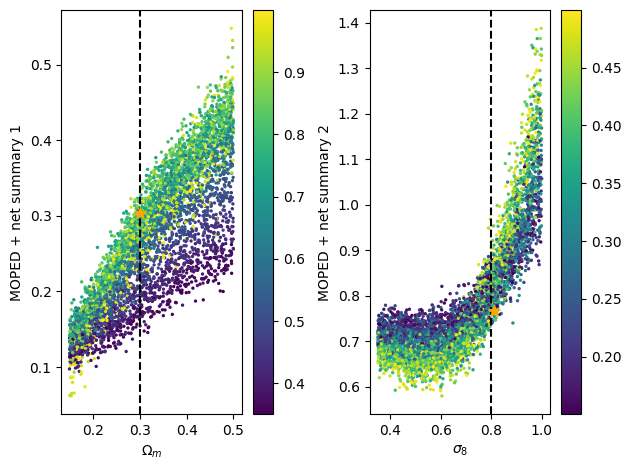

In [134]:
plt.subplot(121)
im = plt.scatter(prior_theta[:, 0], outputs[:, 0], s=2, c=prior_theta[:, 1])
plt.axvline(θ_fid[0], c="k", ls="--")
plt.scatter(target_theta[0], network_target[:, 0], c="orange", marker="*", s=74, zorder=23)

plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"MOPED + net summary 1")
plt.colorbar(im)

plt.subplot(122)
im = plt.scatter(prior_theta[:, 1], outputs[:, 1], s=2, c=prior_theta[:, 0])
plt.axvline(θ_fid[1], c="k", ls="--")
plt.scatter(target_theta[1], network_target[:, 1], c="orange", marker="*", s=74, zorder=23)
plt.ylabel(r"MOPED + net summary 2")
plt.xlabel(r"$\sigma_8$")
plt.colorbar(im)

plt.tight_layout()

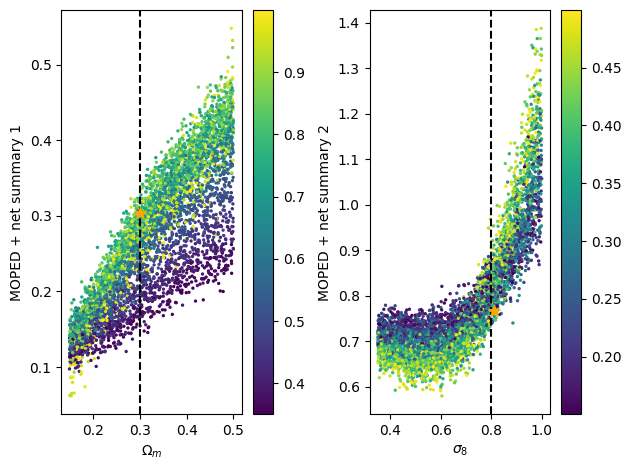

In [135]:
plt.subplot(121)
im = plt.scatter(prior_theta[:, 0], outputs[:, 0], s=2, c=prior_theta[:, 1])
plt.axvline(θ_fid[0], c="k", ls="--")
plt.scatter(target_theta[0], network_target[:, 0], c="orange", marker="*", s=74, zorder=23)

plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"MOPED + net summary 1")
plt.colorbar(im)

plt.subplot(122)
im = plt.scatter(prior_theta[:, 1], outputs[:, 1], s=2, c=prior_theta[:, 0])
plt.axvline(θ_fid[1], c="k", ls="--")
plt.scatter(target_theta[1], network_target[:, 1], c="orange", marker="*", s=74, zorder=23)
plt.ylabel(r"MOPED + net summary 2")
plt.xlabel(r"$\sigma_8$")
plt.colorbar(im)

plt.tight_layout()

In [136]:
NOISEAMP

0.25

In [137]:
# SAVE EVERYTHING FOR DENSITY ESTIMATION !!

np.savez("PM_S8_sbi_N128_smaller_prior_corrected_noiseamp_025",
         moped_summaries=moped_summaries,
         #neural_summaries=neural_summaries,
         prior_theta=prior_theta,
         network_outputs=outputs,
         #model_out_number=model_out_number,
         target=target,
         noisy_target=noisy_target,
         target_theta=target_theta,
         network_target=network_target,
         moped_target=moped_target
        )

In [123]:
outputs.shape

(5000, 2)

In [124]:
prior_theta.shape, outputs.shape, moped_summaries.shape

((5000, 2), (5000, 2), (5000, 2))

In [393]:
IMNN.F

Array([[8880.529 , 1853.0272],
       [1853.0272, 1156.5256]], dtype=float32)

In [396]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(IMNN.w))

In [397]:
param_count

41031

In [399]:
128*128*4

65536